# In Codice Ratio Convolutional Neural Network - Test on a full page

In [1]:
import os
from IPython.display import Image
import time

from util import Util
u = Util()
import image_utils as iu
import keras_image_utils as kiu

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(1337)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Merge

In [3]:
import dataset_generator as dataset

## Loading test sets

In [4]:
# letter list
ALPHABET_ALL = dataset.ALPHABET_ALL

(_, _, X_test_22, y_test_22, _) = dataset.generate_all_chars_with_class(verbose=0, plot=False)
(input_shape, X_test_22, Y_test_22) = kiu.adjust_input_output(X_test_22, y_test_22, 22) 
print ("Loaded test set for all the characters")

(_, _, X_test_seg, y_test_seg) = dataset.generate_dataset_for_segmentator(verbose=0, plot=False)
(_, X_test_seg, Y_test_seg) = kiu.adjust_input_output(X_test_seg, y_test_seg, 2)
print ("Loaded test set for good and bad segments")

X_test_char = {}
y_test_char = {}
Y_test_char = {}
for char in ALPHABET_ALL:
    (_, _, X_test_char[char], y_test_char[char]) = dataset.generate_positive_and_negative_labeled(char, verbose=0)
    (_, X_test_char[char], Y_test_char[char]) = kiu.adjust_input_output(X_test_char[char], y_test_char[char], 2)
    print ("Loaded test set for char '" + char + "'")

Loaded test set for all the characters
Loaded test set for good and bad segments
Loaded test set for char 'a'
Loaded test set for char 'c'
Loaded test set for char 'd_mediana'
Loaded test set for char 'e'
Loaded test set for char 'i'
Loaded test set for char 'm'
Loaded test set for char 'n'
Loaded test set for char 'o'
Loaded test set for char 'r'
Loaded test set for char 's_mediana'
Loaded test set for char 't'
Loaded test set for char 'u'
Loaded test set for char 'd_alta'
Loaded test set for char 's_alta'
Loaded test set for char 'b'
Loaded test set for char 'f'
Loaded test set for char 'h'
Loaded test set for char 'l'
Loaded test set for char 'g'
Loaded test set for char 'p'
Loaded test set for char 'q'
Loaded test set for char 's_bassa'


## Constants

In [5]:
# input image dimensions
img_rows, img_cols = 34, 56

# number of networks for ensamble learning
number_of_models = 5

# checkpoints dir
checkpoints_dir = "checkpoints"

# size of pooling area for max pooling
pool_size1 = (2, 2)
pool_size2 = (3, 3)
# convolution kernel size
kernel_size1 = (4, 4)
kernel_size2 = (5, 5)
# dropout rate
dropout = 0.15
# activation
activation = 'relu'

## Helper functions for model definition and load

In [6]:
def initialize_network_single_column(model, nb_classes, nb_filters1, nb_filters2, dense_layer_size1):
    model.add(Convolution2D(nb_filters1, kernel_size1[0], kernel_size1[1],
                            border_mode='valid',
                            input_shape=input_shape, name='covolution_1_' + str(nb_filters1) + '_filters'))
    model.add(Activation(activation, name='activation_1_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size1, name='max_pooling_1_' + str(pool_size1) + '_pool_size'))
    model.add(Convolution2D(nb_filters2, kernel_size2[0], kernel_size2[1]))
    model.add(Activation(activation, name='activation_2_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size2, name='max_pooling_1_' + str(pool_size2) + '_pool_size'))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense_layer_size1, name='fully_connected_1_' + str(dense_layer_size1) + '_neurons'))
    model.add(Activation(activation, name='activation_3_' + activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, name='output_' + str(nb_classes) + '_neurons'))
    model.add(Activation('softmax', name='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy', 'precision', 'recall'])

def try_load_checkpoints(model, checkpoints_filepath, warn=True):
    # loading weights from checkpoints 
    if os.path.exists(checkpoints_filepath):
        model.load_weights(checkpoints_filepath)
    elif warn: 
        print('Warning: ' + checkpoints_filepath + ' could not be loaded')

def initialize_network_multi_column(merged_model, models):
    merged_model.add(Merge(models, mode='ave'))
    merged_model.compile(loss='categorical_crossentropy',
                         optimizer='adadelta',
                         metrics=['accuracy', 'precision', 'recall'])

def create_and_load_network(number_of_models, checkpoint_paths, nb_classes, 
                            nb_filters1, nb_filters2, dense_layer_size1):
    # pseudo random generation of seeds
    seeds = np.random.randint(10000, size=number_of_models)

    # initializing all the models
    models = [None] * number_of_models

    for i in range(number_of_models):
        models[i] = Sequential()
        initialize_network_single_column(models[i], nb_classes, nb_filters1, nb_filters2, dense_layer_size1)
        try_load_checkpoints(models[i], checkpoint_paths[i])
        
    # initializing merged model
    merged_model = Sequential()
    initialize_network_multi_column(merged_model, models)
    
    return (merged_model, models)

## Model load

In [7]:
# 22 classes ocr
ocr_weigts_dir = os.path.join(checkpoints_dir, "09_22-classes")
ocr_weights = [os.path.join(ocr_weigts_dir, "09_ICR_weights.best_0.hdf5"), 
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_1.hdf5"),
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_2.hdf5"),
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_3.hdf5"),
               os.path.join(ocr_weigts_dir, "09_ICR_weights.best_4.hdf5")]
(ocr_model, _) = create_and_load_network(5, ocr_weights, 22, 50, 100, 250)
score = ocr_model.evaluate([np.asarray(X_test_22)] * number_of_models, Y_test_22, verbose=0)
print ("Loaded 22 classes orc model with test error of ", (1-score[2])*100, '%')

# segmentator network (good cut / bad cut)
segmentator_weigts_dir = os.path.join(checkpoints_dir, "letter_not_letter")
segmentator_weights = [os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_0.hdf5"), 
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_1.hdf5"),
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_2.hdf5"),
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_3.hdf5"),
                       os.path.join(segmentator_weigts_dir, "10_ICR_weights.best_4.hdf5")]
(segmentator_model, _) = create_and_load_network(5, segmentator_weights, 2, 50, 100, 250)
score = segmentator_model.evaluate([np.asarray(X_test_seg)] * number_of_models, Y_test_seg, verbose=0)
print ("Loaded binary segmentator model with test error of ", (1-score[2])*100, '%')
print ("---")

# single letter segmentator / ocr 
single_letter_models = {}
single_letter_weights_dir = {}
single_letter_weights = {}
errors = []
for char in ALPHABET_ALL:
    single_letter_weights_dir[char] = os.path.join(checkpoints_dir, char)
    single_letter_weights[char] = [os.path.join(single_letter_weights_dir[char], "0.hdf5"), 
                                   os.path.join(single_letter_weights_dir[char], "1.hdf5"),
                                   os.path.join(single_letter_weights_dir[char], "2.hdf5"),
                                   os.path.join(single_letter_weights_dir[char], "3.hdf5"),
                                   os.path.join(single_letter_weights_dir[char], "4.hdf5")]
    (single_letter_models[char], _) = create_and_load_network(5, single_letter_weights[char], 2, 20, 40, 150)
    score = single_letter_models[char].evaluate([np.asarray(X_test_char[char])] * number_of_models, Y_test_char[char], verbose=0)
    print ("Loaded binary model for '" + char + "', with test error of ", (1-score[2])*100, '%')
    errors.append(1-score[2])
print("Average test error: ", sum(errors) / float(len(errors)) * 100, "%")

Loaded 22 classes orc model with test error of  4.60439568125 %
Loaded binary segmentator model with test error of  5.15200979392 %
---
Loaded binary model for 'a', with test error of  5.76923082017 %
Loaded binary model for 'c', with test error of  7.44680889109 %
Loaded binary model for 'd_mediana', with test error of  3.4482760676 %
Loaded binary model for 'e', with test error of  3.34158415842 %
Loaded binary model for 'i', with test error of  17.9824561404 %
Loaded binary model for 'm', with test error of  9.44700471817 %
Loaded binary model for 'n', with test error of  11.2903225593 %
Loaded binary model for 'o', with test error of  7.35294129334 %
Loaded binary model for 'r', with test error of  6.66666653421 %
Loaded binary model for 's_mediana', with test error of  3.33333611488 %
Loaded binary model for 't', with test error of  5.47945205479 %
Loaded binary model for 'u', with test error of  15.5487804878 %
Loaded binary model for 'd_alta', with test error of  2.32558139535 %

## Helper functions for prediction

In [8]:
def predict_pipeline1(data, count_letter=True):
    start_time = time.time()
    count = 0
    for bad_cut in data:
        flag = False
        count += 1
        bad_cuts = np.asarray([bad_cut])
        if count_letter:
            print ("Predictions for the supposed letter number " + str(count))
        for char in ALPHABET_ALL:
            predictions = single_letter_models[char].predict([bad_cuts] * number_of_models)
            if (predictions[0][1] > predictions[0][0]):
                print ("Cut " + str(count) + " has been classified as good corresponding to char '" +\
                       char + "' with a confidence of " + str(predictions[0][1] * 100) + "%")
                flag = True
        if not flag:
            print ("Bad cut")
        print ("---")
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)
        
def predict_pipeline2(data, count_letter=True):
    start_time = time.time()
    count = 0
    for bad_cut in data:
        count += 1
        bad_cuts = np.asarray([bad_cut])
        if count_letter:
            print ("Predictions for the supposed letter number " + str(count))
        predictions = segmentator_model.predict([bad_cuts] * number_of_models)
        if (predictions[0][1] > predictions[0][0]):
            predictions = ocr_model.predict([bad_cuts] * number_of_models)
            ind = (-predictions[0]).argsort()[:3]
            for i in ind:
                print ("Good cut corresponding to letter '" + ALPHABET_ALL[i] + \
                   "' with a confidence of " + str(predictions[0][i] * 100) + "%")
        else: 
            print ("Bad cut with a confidence of " + str(predictions[0][0] * 100) + "%")
        print ("---")
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)
        
def predict_pipeline3(data, count_letter=True):
    start_time = time.time()
    count = 0
    for bad_cut in data:
        flag = False
        count += 1
        bad_cuts = np.asarray([bad_cut])
        if count_letter:
            print ("Predictions for the supposed letter number " + str(count))
        for char in ALPHABET_ALL:
            predictions = single_letter_models[char].predict([bad_cuts] * number_of_models)
            if (predictions[0][1] > predictions[0][0]):
                print ("Good cut with a confidence of " + str(predictions[0][1] * 100) + "% by letter '" + char + "'")
                flag = True
        if flag:
            predictions = ocr_model.predict([bad_cuts] * number_of_models)
            ind = (-predictions[0]).argsort()[:3]
            for i in ind:
                print ("Good cut corresponding to letter '" + ALPHABET_ALL[i] + \
                   "' with a confidence of " + str(predictions[0][i] * 100) + "%")
        else: 
            print ("Bad cut")
        print ("---")
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)

def predict_pipeline4(data, count_letter=True):
    start_time = time.time()
    count = 0
    for bad_cut in data:
        count += 1
        bad_cuts = np.asarray([bad_cut])
        if count_letter:
            print ("Predictions for the supposed letter number " + str(count))
        predictions = segmentator_model.predict([bad_cuts] * number_of_models)
        if (predictions[0][1] > predictions[0][0]):
            for char in ALPHABET_ALL:
                predictions = single_letter_models[char].predict([bad_cuts] * number_of_models)
                if (predictions[0][1] > predictions[0][0]):
                    print ("Good cut with a confidence of " + str(predictions[0][1] * 100) + "% by letter '" + char + "'")
        else: 
            print ("Bad cut with a confidence of " + str(predictions[0][0] * 100) + "%")
        print ("---")
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)

## Experiment

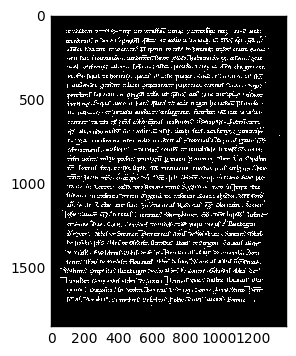

In [10]:
u.plot_image(iu.load_sample("not_code/048r.png"), (1843, 1397))

Examples: 


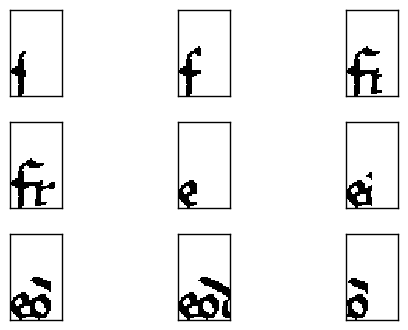

In [18]:
files = []
folders = []
for (path, dirnames, filenames) in os.walk(os.path.join('not_code','all_windows_048r')):
    folders.extend(os.path.join(path, name) for name in dirnames)
    files.extend(os.path.join(path, name) for name in filenames)
    
cuts = iu.open_many_samples(files)
(cuts, _) = kiu.adjust_input(np.asarray(cuts))

print ("Examples: ")
u.plot_some_images(cuts[:9], (img_cols, img_rows), grid_x=3, grid_y=3)

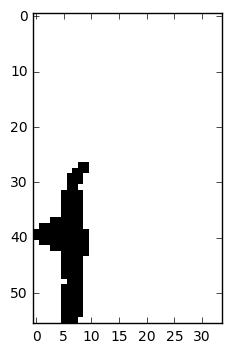

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 50.2098679543%
---
Elapsed time: 0.10114598274230957
Pipeline 2
Bad cut with a confidence of 99.7132599354%
---
Elapsed time: 0.0065097808837890625
Pipeline 3
Good cut with a confidence of 50.2098679543% by letter 's_alta'
Good cut corresponding to letter 'l' with a confidence of 63.8110995293%
Good cut corresponding to letter 's_alta' with a confidence of 36.1380845308%
Good cut corresponding to letter 'f' with a confidence of 0.0505001109559%
---
Elapsed time: 0.12618207931518555
Pipeline 4
Bad cut with a confidence of 99.7132599354%
---
Elapsed time: 0.0060083866119384766


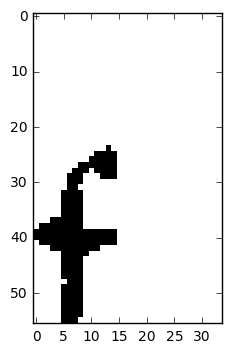

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.6133804321%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 90.7884418964%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 95.0444042683%
---
Elapsed time: 0.10213136672973633
Pipeline 2
Good cut corresponding to letter 'f' with a confidence of 59.5030844212%
Good cut corresponding to letter 's_alta' with a confidence of 40.496763587%
Good cut corresponding to letter 'b' with a confidence of 0.000126669669953%
---
Elapsed time: 0.012017250061035156
Pipeline 3
Good cut with a confidence of 99.6133804321% by letter 's_mediana'
Good cut with a confidence of 90.7884418964% by letter 's_alta'
Good cut with a confidence of 95.0444042683% by letter 'f'
Good cut corresponding to letter 'f' with a confidence of 59.5030844212%
Good cut corresponding to letter 's_alta' with a confidence of 40.496763587%
Good cut corresponding

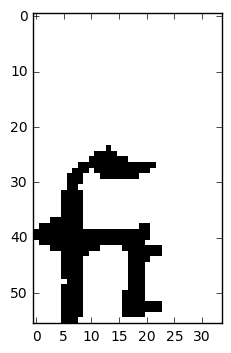

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 58.7788939476%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8273253441%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 87.2564673424%
Cut 1 has been classified as good corresponding to char 'g' with a confidence of 59.478867054%
---
Elapsed time: 0.13519525527954102
Pipeline 2
Good cut corresponding to letter 'f' with a confidence of 99.7421145439%
Good cut corresponding to letter 's_alta' with a confidence of 0.256811641157%
Good cut corresponding to letter 'b' with a confidence of 0.000996932431008%
---
Elapsed time: 0.01602339744567871
Pipeline 3
Good cut with a confidence of 58.7788939476% by letter 'a'
Good cut with a confidence of 99.8273253441% by letter 's_mediana'
Good cut with a confidence of 87.2564673424% by letter 'f'
Good cut with a confidence of 59.478867054% by letter 'g'
Good cut corresponding to le

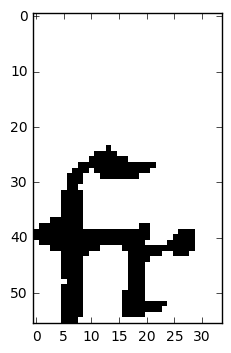

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 65.0416254997%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8827934265%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 71.4920699596%
---
Elapsed time: 0.09320259094238281
Pipeline 2
Bad cut with a confidence of 68.258202076%
---
Elapsed time: 0.005006551742553711
Pipeline 3
Good cut with a confidence of 65.0416254997% by letter 'a'
Good cut with a confidence of 99.8827934265% by letter 's_mediana'
Good cut with a confidence of 71.4920699596% by letter 'f'
Good cut corresponding to letter 'f' with a confidence of 99.9975025654%
Good cut corresponding to letter 's_alta' with a confidence of 0.00201458278752%
Good cut corresponding to letter 'b' with a confidence of 0.000429619512943%
---
Elapsed time: 0.09163236618041992
Pipeline 4
Bad cut with a confidence of 68.258202076%
---
Elapsed time: 0.005507707595825195


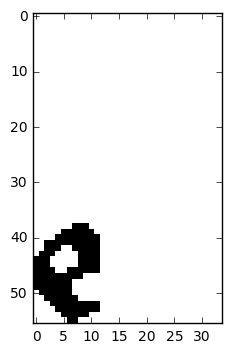

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 98.6689567566%
Cut 1 has been classified as good corresponding to char 'o' with a confidence of 65.8211529255%
Cut 1 has been classified as good corresponding to char 's_bassa' with a confidence of 60.6625914574%
---
Elapsed time: 0.08562374114990234
Pipeline 2
Good cut corresponding to letter 'e' with a confidence of 99.9955773354%
Good cut corresponding to letter 'o' with a confidence of 0.00415966133005%
Good cut corresponding to letter 's_bassa' with a confidence of 0.000127830742258%
---
Elapsed time: 0.011516809463500977
Pipeline 3
Good cut with a confidence of 98.6689567566% by letter 'e'
Good cut with a confidence of 65.8211529255% by letter 'o'
Good cut with a confidence of 60.6625914574% by letter 's_bassa'
Good cut corresponding to letter 'e' with a confidence of 99.9955773354%
Good cut corresponding to letter 'o' with a confidence of 0.00415966133005%
Good cut corresponding to letter

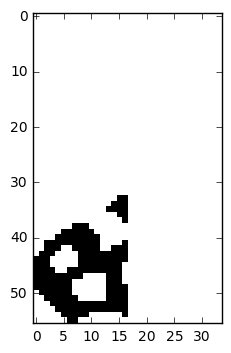

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 74.0866363049%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 62.8022551537%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 52.5276243687%
---
Elapsed time: 0.10665440559387207
Pipeline 2
Bad cut with a confidence of 52.9847979546%
---
Elapsed time: 0.005007266998291016
Pipeline 3
Good cut with a confidence of 74.0866363049% by letter 'e'
Good cut with a confidence of 62.8022551537% by letter 's_mediana'
Good cut with a confidence of 52.5276243687% by letter 'd_alta'
Good cut corresponding to letter 'e' with a confidence of 98.6429393291%
Good cut corresponding to letter 'd_alta' with a confidence of 1.03034991771%
Good cut corresponding to letter 's_bassa' with a confidence of 0.212394376285%
---
Elapsed time: 0.08862781524658203
Pipeline 4
Bad cut with a confidence of 52.9847979546%
---
Elapsed time: 0.00550842285

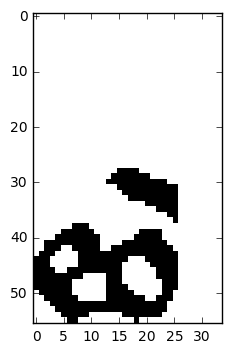

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 56.7161917686%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.9741077423%
---
Elapsed time: 0.10715484619140625
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.007010221481323242
Pipeline 3
Good cut with a confidence of 56.7161917686% by letter 'a'
Good cut with a confidence of 99.9741077423% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 89.1114354134%
Good cut corresponding to letter 'f' with a confidence of 6.3882574439%
Good cut corresponding to letter 's_mediana' with a confidence of 2.69183274359%
---
Elapsed time: 0.11366415023803711
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.006509542465209961


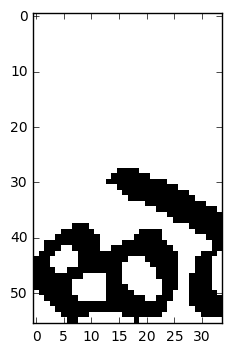

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.1781711578%
---
Elapsed time: 0.11616635322570801
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.006509304046630859
Pipeline 3
Good cut with a confidence of 99.1781711578% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9983131886%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.00161002117238%
Good cut corresponding to letter 'b' with a confidence of 5.25757286596e-05%
---
Elapsed time: 0.1056528091430664
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0055081844329833984


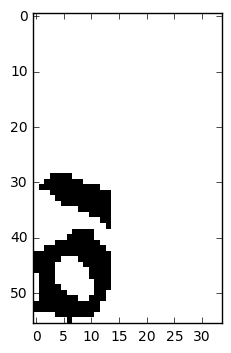

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 69.0137863159%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.9852836132%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 61.9858622551%
---
Elapsed time: 0.09461522102355957
Pipeline 2
Bad cut with a confidence of 99.9961256981%
---
Elapsed time: 0.005507707595825195
Pipeline 3
Good cut with a confidence of 69.0137863159% by letter 'c'
Good cut with a confidence of 99.9852836132% by letter 's_mediana'
Good cut with a confidence of 61.9858622551% by letter 'f'
Good cut corresponding to letter 'd_alta' with a confidence of 61.5394115448%
Good cut corresponding to letter 's_mediana' with a confidence of 18.2683899999%
Good cut corresponding to letter 's_bassa' with a confidence of 15.678486228%
---
Elapsed time: 0.1031496524810791
Pipeline 4
Bad cut with a confidence of 99.9961256981%
---
Elapsed time: 0.0070099830627441

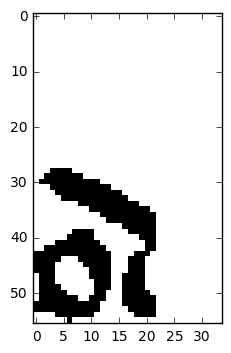

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.9000668526%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 89.7640526295%
---
Elapsed time: 0.09513688087463379
Pipeline 2
Bad cut with a confidence of 92.2925949097%
---
Elapsed time: 0.007010698318481445
Pipeline 3
Good cut with a confidence of 99.9000668526% by letter 's_mediana'
Good cut with a confidence of 89.7640526295% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9367058277%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.0632785260677%
Good cut corresponding to letter 's_mediana' with a confidence of 1.2329587662e-05%
---
Elapsed time: 0.09914350509643555
Pipeline 4
Bad cut with a confidence of 92.2925949097%
---
Elapsed time: 0.005507946014404297


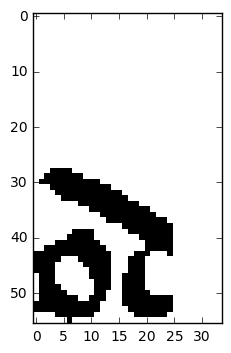

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8906254768%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 89.0914618969%
---
Elapsed time: 0.10014462471008301
Pipeline 2
Bad cut with a confidence of 99.1298019886%
---
Elapsed time: 0.007511138916015625
Pipeline 3
Good cut with a confidence of 99.8906254768% by letter 's_mediana'
Good cut with a confidence of 89.0914618969% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9837577343%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.016239816614%
Good cut corresponding to letter 's_mediana' with a confidence of 9.04773322929e-07%
---
Elapsed time: 0.0951375961303711
Pipeline 4
Bad cut with a confidence of 99.1298019886%
---
Elapsed time: 0.005507946014404297


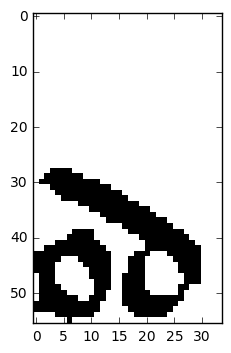

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.891269207%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 89.5523190498%
---
Elapsed time: 0.09815001487731934
Pipeline 2
Bad cut with a confidence of 99.9997317791%
---
Elapsed time: 0.005007505416870117
Pipeline 3
Good cut with a confidence of 99.891269207% by letter 's_mediana'
Good cut with a confidence of 89.5523190498% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9991238117%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.000878757600731%
Good cut corresponding to letter 's_mediana' with a confidence of 5.30725203368e-10%
---
Elapsed time: 0.09113121032714844
Pipeline 4
Bad cut with a confidence of 99.9997317791%
---
Elapsed time: 0.0050067901611328125


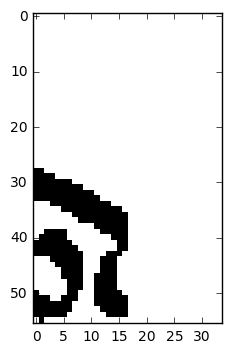

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.7065186501%
---
Elapsed time: 0.09163260459899902
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 99.7784435749%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.217857700773%
Good cut corresponding to letter 's_bassa' with a confidence of 0.0029776008887%
---
Elapsed time: 0.010015249252319336
Pipeline 3
Good cut with a confidence of 99.7065186501% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.7784435749%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.217857700773%
Good cut corresponding to letter 's_bassa' with a confidence of 0.0029776008887%
---
Elapsed time: 0.0880117416381836
Pipeline 4
Good cut with a confidence of 99.7065186501% by letter 's_mediana'
---
Elapsed time: 0.1001441478729248


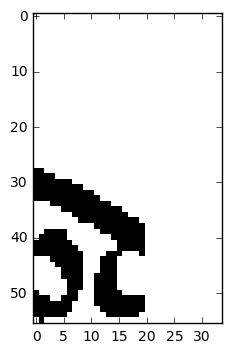

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8374342918%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 68.0777192116%
---
Elapsed time: 0.11366462707519531
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 99.9736785889%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.0263127993094%
Good cut corresponding to letter 's_mediana' with a confidence of 4.68802952014e-06%
---
Elapsed time: 0.010514497756958008
Pipeline 3
Good cut with a confidence of 99.8374342918% by letter 's_mediana'
Good cut with a confidence of 68.0777192116% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9736785889%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.0263127993094%
Good cut corresponding to letter 's_mediana' with a confidence of 4.68802952014e-06%
---
Elapsed time: 0.08862853050231934
Pipeline 4
Good cut with

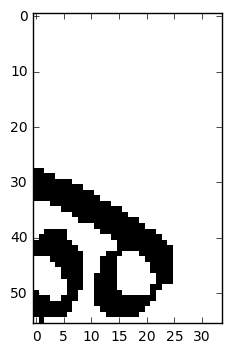

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8086094856%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 83.4024727345%
---
Elapsed time: 0.10415124893188477
Pipeline 2
Bad cut with a confidence of 79.7071039677%
---
Elapsed time: 0.0055084228515625
Pipeline 3
Good cut with a confidence of 99.8086094856% by letter 's_mediana'
Good cut with a confidence of 83.4024727345% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.999320507%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.000678237711327%
Good cut corresponding to letter 's_mediana' with a confidence of 1.07215000766e-08%
---
Elapsed time: 0.08794403076171875
Pipeline 4
Bad cut with a confidence of 79.7071039677%
---
Elapsed time: 0.006008625030517578


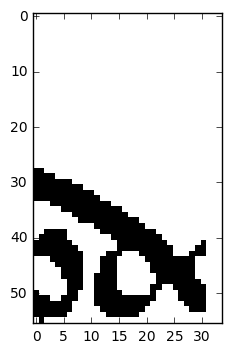

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.6446728706%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 57.1255624294%
---
Elapsed time: 0.08962869644165039
Pipeline 2
Bad cut with a confidence of 99.8622119427%
---
Elapsed time: 0.006008625030517578
Pipeline 3
Good cut with a confidence of 99.6446728706% by letter 's_mediana'
Good cut with a confidence of 57.1255624294% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9996542931%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.000349873448613%
Good cut corresponding to letter 'q' with a confidence of 1.54401463837e-08%
---
Elapsed time: 0.09814214706420898
Pipeline 4
Bad cut with a confidence of 99.8622119427%
---
Elapsed time: 0.0055081844329833984


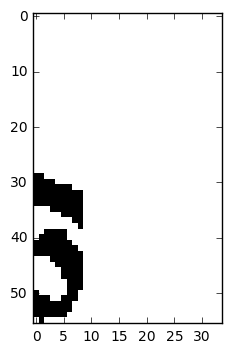

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.7653782368%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 50.4057407379%
---
Elapsed time: 0.09613823890686035
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.004506349563598633
Pipeline 3
Good cut with a confidence of 99.7653782368% by letter 's_mediana'
Good cut with a confidence of 50.4057407379% by letter 'f'
Good cut corresponding to letter 's_alta' with a confidence of 68.0665850639%
Good cut corresponding to letter 'l' with a confidence of 21.6689556837%
Good cut corresponding to letter 's_bassa' with a confidence of 8.99686440825%
---
Elapsed time: 0.09063148498535156
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0050067901611328125


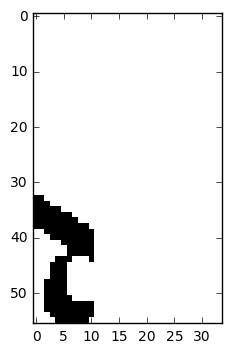

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 94.467151165%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 53.2829403877%
---
Elapsed time: 0.09063148498535156
Pipeline 2
Bad cut with a confidence of 99.9990463257%
---
Elapsed time: 0.005006074905395508
Pipeline 3
Good cut with a confidence of 94.467151165% by letter 's_mediana'
Good cut with a confidence of 53.2829403877% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 38.9984577894%
Good cut corresponding to letter 'c' with a confidence of 30.7206630707%
Good cut corresponding to letter 'a' with a confidence of 14.3013343215%
---
Elapsed time: 0.08362102508544922
Pipeline 4
Bad cut with a confidence of 99.9990463257%
---
Elapsed time: 0.005007505416870117


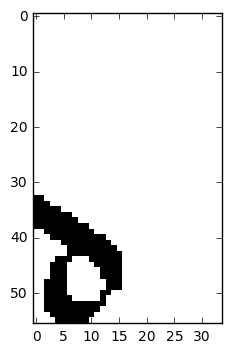

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 91.7983055115%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 98.5044121742%
---
Elapsed time: 0.0926356315612793
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 99.996316433%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.00365731248166%
Good cut corresponding to letter 'o' with a confidence of 1.36477495971e-05%
---
Elapsed time: 0.010515689849853516
Pipeline 3
Good cut with a confidence of 91.7983055115% by letter 's_mediana'
Good cut with a confidence of 98.5044121742% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.996316433%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.00365731248166%
Good cut corresponding to letter 'o' with a confidence of 1.36477495971e-05%
---
Elapsed time: 0.09163260459899902
Pipeline 4
Good cut with a confidence of 

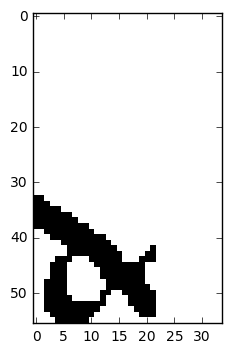

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 94.1665649414%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 98.2818424702%
---
Elapsed time: 0.10965847969055176
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 99.9993920326%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.000596665495323%
Good cut corresponding to letter 'a' with a confidence of 5.59678419165e-06%
---
Elapsed time: 0.011016368865966797
Pipeline 3
Good cut with a confidence of 94.1665649414% by letter 's_mediana'
Good cut with a confidence of 98.2818424702% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9993920326%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.000596665495323%
Good cut corresponding to letter 'a' with a confidence of 5.59678419165e-06%
---
Elapsed time: 0.08712530136108398
Pipeline 4
Good cut with a confidenc

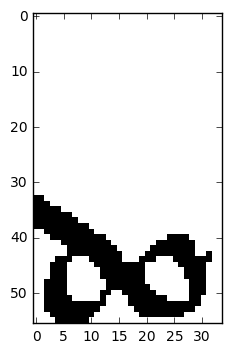

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 97.7135300636%
---
Elapsed time: 0.10915803909301758
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.007008790969848633
Pipeline 3
Good cut with a confidence of 97.7135300636% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9644756317%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.0342669838574%
Good cut corresponding to letter 'q' with a confidence of 0.00087656226242%
---
Elapsed time: 0.09313535690307617
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.007010459899902344


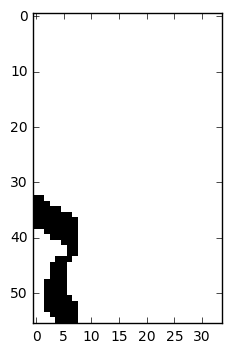

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 80.7643413544%
---
Elapsed time: 0.09012985229492188
Pipeline 2
Bad cut with a confidence of 99.9999403954%
---
Elapsed time: 0.0050067901611328125
Pipeline 3
Good cut with a confidence of 80.7643413544% by letter 's_mediana'
Good cut corresponding to letter 'i' with a confidence of 88.4215056896%
Good cut corresponding to letter 'l' with a confidence of 11.2869128585%
Good cut corresponding to letter 'c' with a confidence of 0.0906207947992%
---
Elapsed time: 0.09563827514648438
Pipeline 4
Bad cut with a confidence of 99.9999403954%
---
Elapsed time: 0.005007505416870117


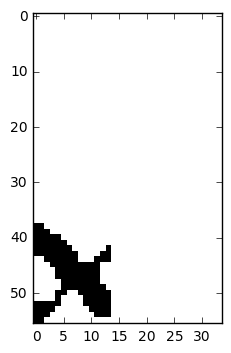

Pipeline 1
Bad cut
---
Elapsed time: 0.12518024444580078
Pipeline 2
Bad cut with a confidence of 90.6225562096%
---
Elapsed time: 0.008512496948242188
Pipeline 3
Bad cut
---
Elapsed time: 0.12117481231689453
Pipeline 4
Bad cut with a confidence of 90.6225562096%
---
Elapsed time: 0.0055081844329833984


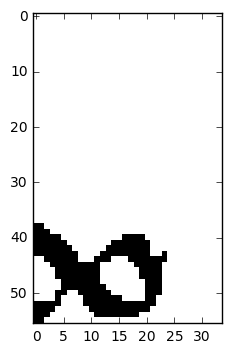

Pipeline 1
Bad cut
---
Elapsed time: 0.09263372421264648
Pipeline 2
Bad cut with a confidence of 99.9990165234%
---
Elapsed time: 0.005007266998291016
Pipeline 3
Bad cut
---
Elapsed time: 0.1111612319946289
Pipeline 4
Bad cut with a confidence of 99.9990165234%
---
Elapsed time: 0.006508588790893555


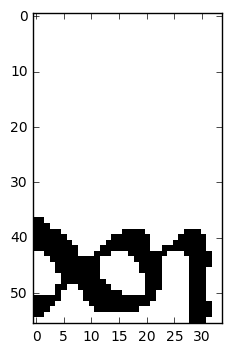

Pipeline 1
Bad cut
---
Elapsed time: 0.12267637252807617
Pipeline 2
Bad cut with a confidence of 99.8564064503%
---
Elapsed time: 0.011517047882080078
Pipeline 3
Bad cut
---
Elapsed time: 0.08562374114990234
Pipeline 4
Bad cut with a confidence of 99.8564064503%
---
Elapsed time: 0.006509542465209961


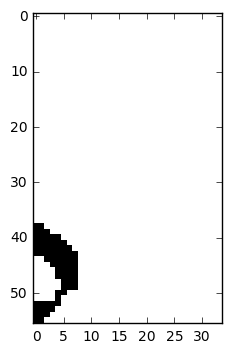

Pipeline 1
Bad cut
---
Elapsed time: 0.11917304992675781
Pipeline 2
Bad cut with a confidence of 99.4353473186%
---
Elapsed time: 0.006508588790893555
Pipeline 3
Bad cut
---
Elapsed time: 0.116668701171875
Pipeline 4
Bad cut with a confidence of 99.4353473186%
---
Elapsed time: 0.006008625030517578


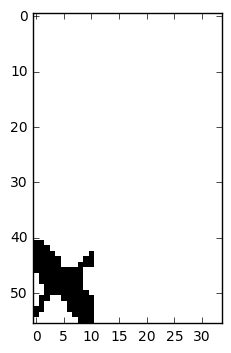

Pipeline 1
Bad cut
---
Elapsed time: 0.1141660213470459
Pipeline 2
Bad cut with a confidence of 98.4357059002%
---
Elapsed time: 0.008010625839233398
Pipeline 3
Bad cut
---
Elapsed time: 0.1071319580078125
Pipeline 4
Bad cut with a confidence of 98.4357059002%
---
Elapsed time: 0.007010698318481445


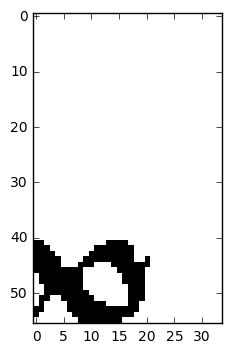

Pipeline 1
Cut 1 has been classified as good corresponding to char 'r' with a confidence of 51.3638019562%
---
Elapsed time: 0.0976414680480957
Pipeline 2
Bad cut with a confidence of 77.0226359367%
---
Elapsed time: 0.006509542465209961
Pipeline 3
Good cut with a confidence of 51.3638019562% by letter 'r'
Good cut corresponding to letter 'e' with a confidence of 68.9640402794%
Good cut corresponding to letter 'a' with a confidence of 19.8230996728%
Good cut corresponding to letter 'o' with a confidence of 10.229549557%
---
Elapsed time: 0.12267780303955078
Pipeline 4
Bad cut with a confidence of 77.0226359367%
---
Elapsed time: 0.00901174545288086


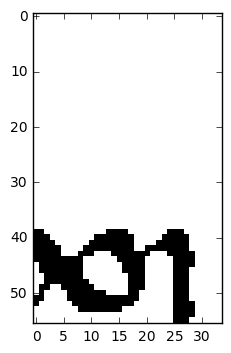

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 87.5767886639%
---
Elapsed time: 0.11366438865661621
Pipeline 2
Bad cut with a confidence of 95.0585484505%
---
Elapsed time: 0.00851297378540039
Pipeline 3
Good cut with a confidence of 87.5767886639% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 99.9951183796%
Good cut corresponding to letter 'e' with a confidence of 0.00487117213197%
Good cut corresponding to letter 'd_mediana' with a confidence of 8.12831899566e-06%
---
Elapsed time: 0.10815596580505371
Pipeline 4
Bad cut with a confidence of 95.0585484505%
---
Elapsed time: 0.0065097808837890625


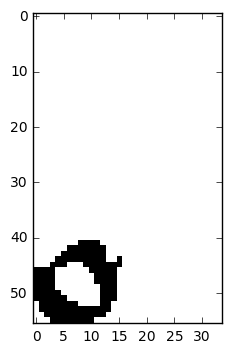

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 59.1730475426%
Cut 1 has been classified as good corresponding to char 'o' with a confidence of 92.1915411949%
---
Elapsed time: 0.11466574668884277
Pipeline 2
Bad cut with a confidence of 71.1030006409%
---
Elapsed time: 0.0075109004974365234
Pipeline 3
Good cut with a confidence of 59.1730475426% by letter 'a'
Good cut with a confidence of 92.1915411949% by letter 'o'
Good cut corresponding to letter 'o' with a confidence of 83.8000118732%
Good cut corresponding to letter 'a' with a confidence of 15.1417762041%
Good cut corresponding to letter 'e' with a confidence of 0.599347241223%
---
Elapsed time: 0.13419413566589355
Pipeline 4
Bad cut with a confidence of 71.1030006409%
---
Elapsed time: 0.006009101867675781


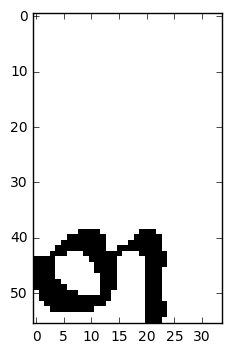

Pipeline 1
Bad cut
---
Elapsed time: 0.09964370727539062
Pipeline 2
Bad cut with a confidence of 99.8163998127%
---
Elapsed time: 0.0075113773345947266
Pipeline 3
Bad cut
---
Elapsed time: 0.1276843547821045
Pipeline 4
Bad cut with a confidence of 99.8163998127%
---
Elapsed time: 0.005507946014404297


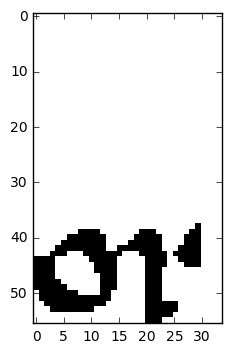

Pipeline 1
Bad cut
---
Elapsed time: 0.11416411399841309
Pipeline 2
Bad cut with a confidence of 99.9998927116%
---
Elapsed time: 0.0065097808837890625
Pipeline 3
Bad cut
---
Elapsed time: 0.11867141723632812
Pipeline 4
Bad cut with a confidence of 99.9998927116%
---
Elapsed time: 0.00600886344909668


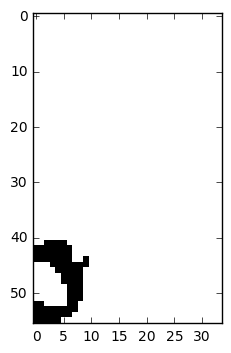

Pipeline 1
Bad cut
---
Elapsed time: 0.12067484855651855
Pipeline 2
Bad cut with a confidence of 98.9323139191%
---
Elapsed time: 0.005507707595825195
Pipeline 3
Bad cut
---
Elapsed time: 0.12367892265319824
Pipeline 4
Bad cut with a confidence of 98.9323139191%
---
Elapsed time: 0.006008625030517578


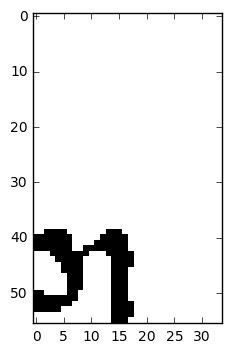

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 73.0855047703%
---
Elapsed time: 0.11339139938354492
Pipeline 2
Good cut corresponding to letter 'n' with a confidence of 94.5878863335%
Good cut corresponding to letter 'u' with a confidence of 4.63468655944%
Good cut corresponding to letter 'o' with a confidence of 0.495992228389%
---
Elapsed time: 0.015522956848144531
Pipeline 3
Good cut with a confidence of 73.0855047703% by letter 'n'
Good cut corresponding to letter 'n' with a confidence of 94.5878863335%
Good cut corresponding to letter 'u' with a confidence of 4.63468655944%
Good cut corresponding to letter 'o' with a confidence of 0.495992228389%
---
Elapsed time: 0.09864234924316406
Pipeline 4
Good cut with a confidence of 73.0855047703% by letter 'n'
---
Elapsed time: 0.11166167259216309


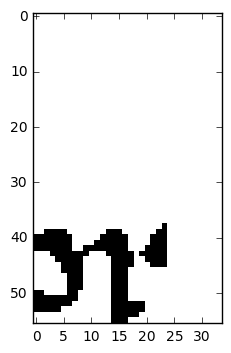

Pipeline 1
Bad cut
---
Elapsed time: 0.10765480995178223
Pipeline 2
Bad cut with a confidence of 97.5381076336%
---
Elapsed time: 0.006509542465209961
Pipeline 3
Bad cut
---
Elapsed time: 0.09263396263122559
Pipeline 4
Bad cut with a confidence of 97.5381076336%
---
Elapsed time: 0.006009101867675781


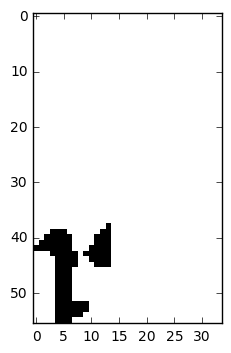

Pipeline 1
Cut 1 has been classified as good corresponding to char 'r' with a confidence of 97.7410674095%
---
Elapsed time: 0.10264897346496582
Pipeline 2
Good cut corresponding to letter 'r' with a confidence of 99.9929249287%
Good cut corresponding to letter 'e' with a confidence of 0.0061959544837%
Good cut corresponding to letter 'u' with a confidence of 0.000367240863852%
---
Elapsed time: 0.012017250061035156
Pipeline 3
Good cut with a confidence of 97.7410674095% by letter 'r'
Good cut corresponding to letter 'r' with a confidence of 99.9929249287%
Good cut corresponding to letter 'e' with a confidence of 0.0061959544837%
Good cut corresponding to letter 'u' with a confidence of 0.000367240863852%
---
Elapsed time: 0.10415101051330566
Pipeline 4
Good cut with a confidence of 97.7410674095% by letter 'r'
---
Elapsed time: 0.10815644264221191


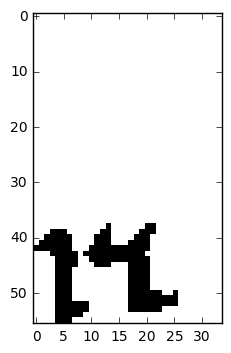

Pipeline 1
Bad cut
---
Elapsed time: 0.09613990783691406
Pipeline 2
Bad cut with a confidence of 98.4277129173%
---
Elapsed time: 0.005507230758666992
Pipeline 3
Bad cut
---
Elapsed time: 0.09163236618041992
Pipeline 4
Bad cut with a confidence of 98.4277129173%
---
Elapsed time: 0.005007266998291016


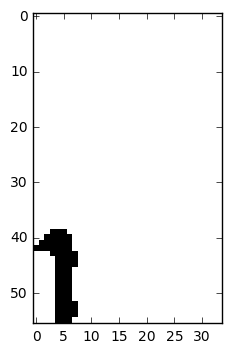

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 92.9046750069%
---
Elapsed time: 0.12067508697509766
Pipeline 2
Good cut corresponding to letter 'i' with a confidence of 99.9982476234%
Good cut corresponding to letter 'a' with a confidence of 0.000624859831078%
Good cut corresponding to letter 't' with a confidence of 0.000493649986311%
---
Elapsed time: 0.013519287109375
Pipeline 3
Good cut with a confidence of 92.9046750069% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9982476234%
Good cut corresponding to letter 'a' with a confidence of 0.000624859831078%
Good cut corresponding to letter 't' with a confidence of 0.000493649986311%
---
Elapsed time: 0.1467125415802002
Pipeline 4
Good cut with a confidence of 92.9046750069% by letter 'i'
---
Elapsed time: 0.13118958473205566


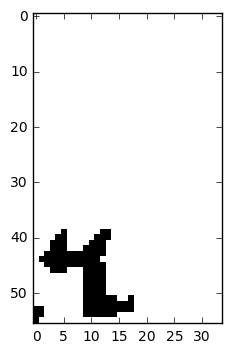

Pipeline 1
Bad cut
---
Elapsed time: 0.1246805191040039
Pipeline 2
Bad cut with a confidence of 99.9604225159%
---
Elapsed time: 0.006509304046630859
Pipeline 3
Bad cut
---
Elapsed time: 0.12017345428466797
Pipeline 4
Bad cut with a confidence of 99.9604225159%
---
Elapsed time: 0.008512735366821289


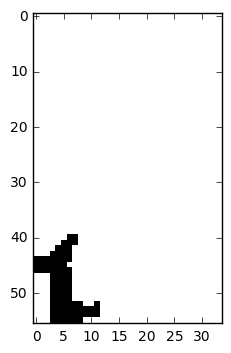

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 58.7424337864%
---
Elapsed time: 0.1221768856048584
Pipeline 2
Bad cut with a confidence of 99.8711585999%
---
Elapsed time: 0.00600886344909668
Pipeline 3
Good cut with a confidence of 58.7424337864% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 91.9700503349%
Good cut corresponding to letter 'e' with a confidence of 5.61695620418%
Good cut corresponding to letter 'c' with a confidence of 2.22682654858%
---
Elapsed time: 0.13920140266418457
Pipeline 4
Bad cut with a confidence of 99.8711585999%
---
Elapsed time: 0.006508827209472656


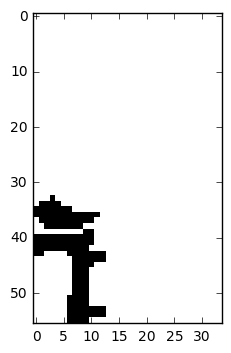

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 96.1239993572%
---
Elapsed time: 0.11616754531860352
Pipeline 2
Bad cut with a confidence of 99.8282730579%
---
Elapsed time: 0.007010459899902344
Pipeline 3
Good cut with a confidence of 96.1239993572% by letter 's_mediana'
Good cut corresponding to letter 's_mediana' with a confidence of 25.7482230663%
Good cut corresponding to letter 's_alta' with a confidence of 21.3872075081%
Good cut corresponding to letter 'e' with a confidence of 17.5789862871%
---
Elapsed time: 0.10114645957946777
Pipeline 4
Bad cut with a confidence of 99.8282730579%
---
Elapsed time: 0.007511615753173828


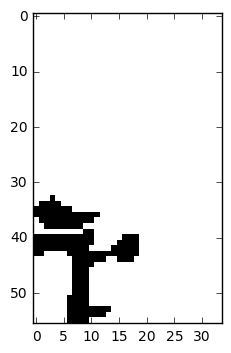

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 94.5034503937%
---
Elapsed time: 0.0981438159942627
Pipeline 2
Good cut corresponding to letter 's_mediana' with a confidence of 70.3842639923%
Good cut corresponding to letter 'a' with a confidence of 15.0683969259%
Good cut corresponding to letter 'e' with a confidence of 10.8952388167%
---
Elapsed time: 0.01401972770690918
Pipeline 3
Good cut with a confidence of 94.5034503937% by letter 's_mediana'
Good cut corresponding to letter 's_mediana' with a confidence of 70.3842639923%
Good cut corresponding to letter 'a' with a confidence of 15.0683969259%
Good cut corresponding to letter 'e' with a confidence of 10.8952388167%
---
Elapsed time: 0.10565662384033203
Pipeline 4
Good cut with a confidence of 94.5034503937% by letter 's_mediana'
---
Elapsed time: 0.12618231773376465


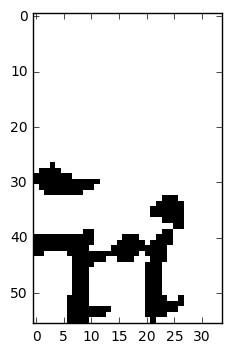

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.9686896801%
---
Elapsed time: 0.12317752838134766
Pipeline 2
Bad cut with a confidence of 99.9158203602%
---
Elapsed time: 0.006009101867675781
Pipeline 3
Good cut with a confidence of 99.9686896801% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 91.2197589874%
Good cut corresponding to letter 'f' with a confidence of 4.99941334128%
Good cut corresponding to letter 'b' with a confidence of 2.76375748217%
---
Elapsed time: 0.1276845932006836
Pipeline 4
Bad cut with a confidence of 99.9158203602%
---
Elapsed time: 0.008011341094970703


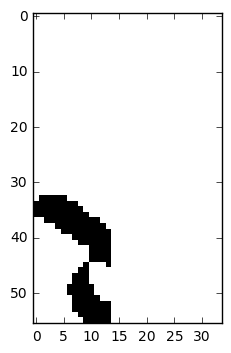

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 88.1164848804%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 55.2221775055%
---
Elapsed time: 0.09864044189453125
Pipeline 2
Bad cut with a confidence of 99.9997496605%
---
Elapsed time: 0.006008625030517578
Pipeline 3
Good cut with a confidence of 88.1164848804% by letter 's_mediana'
Good cut with a confidence of 55.2221775055% by letter 'd_alta'
Good cut corresponding to letter 'a' with a confidence of 85.278403759%
Good cut corresponding to letter 'd_alta' with a confidence of 12.1978439391%
Good cut corresponding to letter 's_bassa' with a confidence of 2.3783929646%
---
Elapsed time: 0.09664011001586914
Pipeline 4
Bad cut with a confidence of 99.9997496605%
---
Elapsed time: 0.005507707595825195


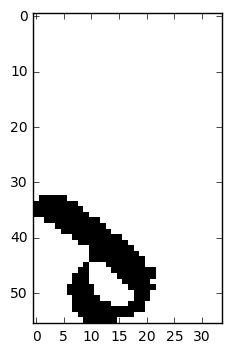

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 97.4570631981%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 99.2198348045%
---
Elapsed time: 0.10465121269226074
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 99.9798417091%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.0198003574042%
Good cut corresponding to letter 'a' with a confidence of 0.000317887020174%
---
Elapsed time: 0.014521598815917969
Pipeline 3
Good cut with a confidence of 97.4570631981% by letter 's_mediana'
Good cut with a confidence of 99.2198348045% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9798417091%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.0198003574042%
Good cut corresponding to letter 'a' with a confidence of 0.000317887020174%
---
Elapsed time: 0.10665512084960938
Pipeline 4
Good cut with a confidence of

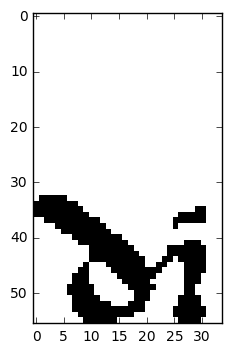

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 53.1335294247%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 89.5505428314%
---
Elapsed time: 0.12668275833129883
Pipeline 2
Bad cut with a confidence of 99.8862564564%
---
Elapsed time: 0.00600886344909668
Pipeline 3
Good cut with a confidence of 53.1335294247% by letter 'a'
Good cut with a confidence of 89.5505428314% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 84.2547059059%
Good cut corresponding to letter 'd_mediana' with a confidence of 15.4659360647%
Good cut corresponding to letter 'a' with a confidence of 0.117695273366%
---
Elapsed time: 0.11316323280334473
Pipeline 4
Bad cut with a confidence of 99.8862564564%
---
Elapsed time: 0.005007505416870117


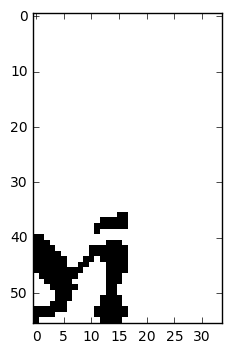

Pipeline 1
Bad cut
---
Elapsed time: 0.11967349052429199
Pipeline 2
Bad cut with a confidence of 92.8977489471%
---
Elapsed time: 0.0060083866119384766
Pipeline 3
Bad cut
---
Elapsed time: 0.08862805366516113
Pipeline 4
Bad cut with a confidence of 92.8977489471%
---
Elapsed time: 0.006509304046630859


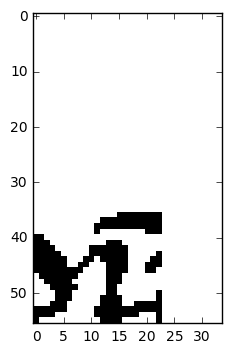

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 53.3459305763%
---
Elapsed time: 0.11065983772277832
Pipeline 2
Bad cut with a confidence of 99.9814212322%
---
Elapsed time: 0.006509542465209961
Pipeline 3
Good cut with a confidence of 53.3459305763% by letter 's_mediana'
Good cut corresponding to letter 's_mediana' with a confidence of 55.1890015602%
Good cut corresponding to letter 'a' with a confidence of 38.4180992842%
Good cut corresponding to letter 'e' with a confidence of 3.55314835906%
---
Elapsed time: 0.11266231536865234
Pipeline 4
Bad cut with a confidence of 99.9814212322%
---
Elapsed time: 0.006008625030517578


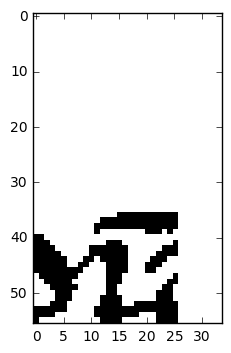

Pipeline 1
Bad cut
---
Elapsed time: 0.11416506767272949
Pipeline 2
Bad cut with a confidence of 99.9399781227%
---
Elapsed time: 0.009012699127197266
Pipeline 3
Bad cut
---
Elapsed time: 0.08612465858459473
Pipeline 4
Bad cut with a confidence of 99.9399781227%
---
Elapsed time: 0.008011817932128906


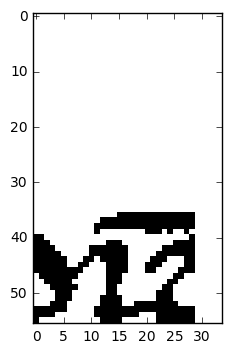

Pipeline 1
Bad cut
---
Elapsed time: 0.10815668106079102
Pipeline 2
Bad cut with a confidence of 99.9999165535%
---
Elapsed time: 0.007010459899902344
Pipeline 3
Bad cut
---
Elapsed time: 0.08762598037719727
Pipeline 4
Bad cut with a confidence of 99.9999165535%
---
Elapsed time: 0.0065097808837890625


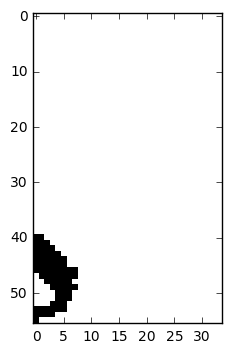

Pipeline 1
Bad cut
---
Elapsed time: 0.09613800048828125
Pipeline 2
Bad cut with a confidence of 98.5496163368%
---
Elapsed time: 0.0055081844329833984
Pipeline 3
Bad cut
---
Elapsed time: 0.0951385498046875
Pipeline 4
Bad cut with a confidence of 98.5496163368%
---
Elapsed time: 0.005506992340087891


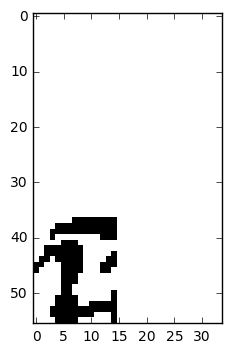

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 71.8161582947%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 71.7599749565%
---
Elapsed time: 0.13269257545471191
Pipeline 2
Bad cut with a confidence of 95.0792789459%
---
Elapsed time: 0.006008625030517578
Pipeline 3
Good cut with a confidence of 71.8161582947% by letter 'e'
Good cut with a confidence of 71.7599749565% by letter 's_mediana'
Good cut corresponding to letter 'e' with a confidence of 98.4413981438%
Good cut corresponding to letter 's_bassa' with a confidence of 0.709379371256%
Good cut corresponding to letter 'o' with a confidence of 0.524741318077%
---
Elapsed time: 0.13920092582702637
Pipeline 4
Bad cut with a confidence of 95.0792789459%
---
Elapsed time: 0.008513689041137695


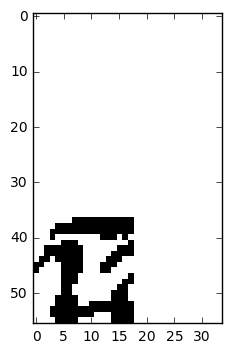

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 57.9278707504%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 56.9289028645%
---
Elapsed time: 0.12518095970153809
Pipeline 2
Bad cut with a confidence of 98.3399510384%
---
Elapsed time: 0.009013652801513672
Pipeline 3
Good cut with a confidence of 57.9278707504% by letter 'e'
Good cut with a confidence of 56.9289028645% by letter 's_mediana'
Good cut corresponding to letter 'e' with a confidence of 86.7178559303%
Good cut corresponding to letter 'o' with a confidence of 6.96503371%
Good cut corresponding to letter 'a' with a confidence of 4.42517325282%
---
Elapsed time: 0.10114645957946777
Pipeline 4
Bad cut with a confidence of 98.3399510384%
---
Elapsed time: 0.005507469177246094


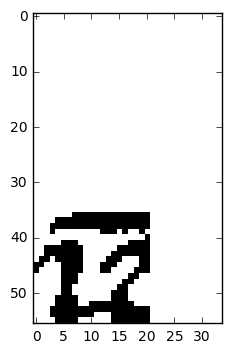

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 81.8807005882%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 78.2555043697%
---
Elapsed time: 0.11266326904296875
Pipeline 2
Bad cut with a confidence of 99.9998867512%
---
Elapsed time: 0.0070095062255859375
Pipeline 3
Good cut with a confidence of 81.8807005882% by letter 'a'
Good cut with a confidence of 78.2555043697% by letter 's_mediana'
Good cut corresponding to letter 'a' with a confidence of 99.7865855694%
Good cut corresponding to letter 's_mediana' with a confidence of 0.189558789134%
Good cut corresponding to letter 'q' with a confidence of 0.0157159840455%
---
Elapsed time: 0.10114669799804688
Pipeline 4
Bad cut with a confidence of 99.9998867512%
---
Elapsed time: 0.007510185241699219


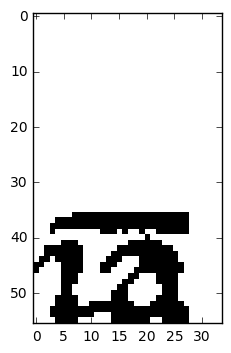

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 52.6082634926%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 94.7268307209%
---
Elapsed time: 0.10615372657775879
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.006509542465209961
Pipeline 3
Good cut with a confidence of 52.6082634926% by letter 'a'
Good cut with a confidence of 94.7268307209% by letter 's_mediana'
Good cut corresponding to letter 's_mediana' with a confidence of 87.9867374897%
Good cut corresponding to letter 'a' with a confidence of 8.20057839155%
Good cut corresponding to letter 'g' with a confidence of 3.19056026638%
---
Elapsed time: 0.09263396263122559
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.006509304046630859


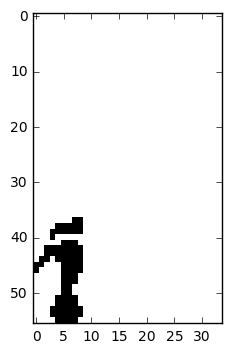

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 64.6095693111%
---
Elapsed time: 0.10665440559387207
Pipeline 2
Bad cut with a confidence of 98.380947113%
---
Elapsed time: 0.006509065628051758
Pipeline 3
Good cut with a confidence of 64.6095693111% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.3959903717%
Good cut corresponding to letter 'l' with a confidence of 0.341319967993%
Good cut corresponding to letter 'e' with a confidence of 0.19535694737%
---
Elapsed time: 0.09814143180847168
Pipeline 4
Bad cut with a confidence of 98.380947113%
---
Elapsed time: 0.008012056350708008


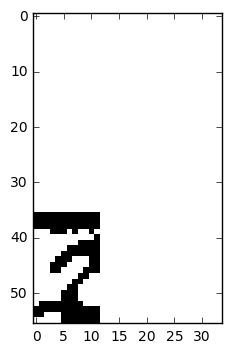

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 86.8506550789%
---
Elapsed time: 0.10415053367614746
Pipeline 2
Bad cut with a confidence of 99.6816039085%
---
Elapsed time: 0.006009101867675781
Pipeline 3
Good cut with a confidence of 86.8506550789% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 78.9650142193%
Good cut corresponding to letter 'i' with a confidence of 20.8139538765%
Good cut corresponding to letter 't' with a confidence of 0.128516554832%
---
Elapsed time: 0.09514021873474121
Pipeline 4
Bad cut with a confidence of 99.6816039085%
---
Elapsed time: 0.005507946014404297


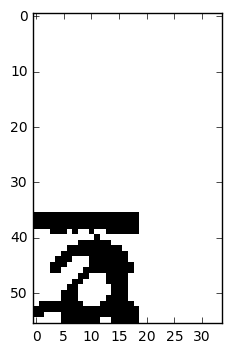

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 72.6236343384%
---
Elapsed time: 0.10014486312866211
Pipeline 2
Bad cut with a confidence of 99.2497265339%
---
Elapsed time: 0.005508899688720703
Pipeline 3
Good cut with a confidence of 72.6236343384% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 99.5048880577%
Good cut corresponding to letter 's_mediana' with a confidence of 0.46284198761%
Good cut corresponding to letter 'g' with a confidence of 0.00993732610368%
---
Elapsed time: 0.10264778137207031
Pipeline 4
Bad cut with a confidence of 99.2497265339%
---
Elapsed time: 0.007009983062744141


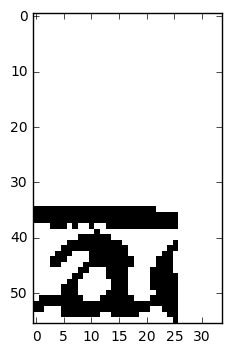

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 73.031270504%
---
Elapsed time: 0.09713912010192871
Pipeline 2
Bad cut with a confidence of 99.8123168945%
---
Elapsed time: 0.00600886344909668
Pipeline 3
Good cut with a confidence of 73.031270504% by letter 's_mediana'
Good cut corresponding to letter 'd_mediana' with a confidence of 54.6097397804%
Good cut corresponding to letter 'g' with a confidence of 43.6009258032%
Good cut corresponding to letter 'p' with a confidence of 0.536988861859%
---
Elapsed time: 0.10065126419067383
Pipeline 4
Bad cut with a confidence of 99.8123168945%
---
Elapsed time: 0.006008625030517578


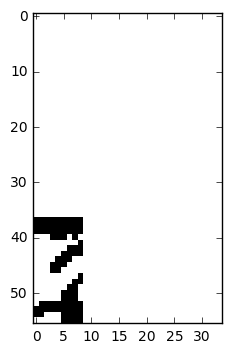

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 62.5289201736%
---
Elapsed time: 0.10565185546875
Pipeline 2
Bad cut with a confidence of 99.8971641064%
---
Elapsed time: 0.006509304046630859
Pipeline 3
Good cut with a confidence of 62.5289201736% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.4275391102%
Good cut corresponding to letter 'l' with a confidence of 0.505891581997%
Good cut corresponding to letter 'a' with a confidence of 0.0302153814118%
---
Elapsed time: 0.10164737701416016
Pipeline 4
Bad cut with a confidence of 99.8971641064%
---
Elapsed time: 0.008511781692504883


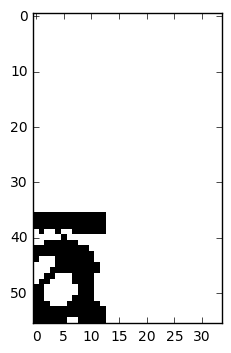

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 90.0188148022%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 72.3188042641%
---
Elapsed time: 0.09502220153808594
Pipeline 2
Bad cut with a confidence of 99.9912381172%
---
Elapsed time: 0.005507946014404297
Pipeline 3
Good cut with a confidence of 90.0188148022% by letter 'a'
Good cut with a confidence of 72.3188042641% by letter 's_mediana'
Good cut corresponding to letter 'e' with a confidence of 78.5622000694%
Good cut corresponding to letter 'a' with a confidence of 14.4511327147%
Good cut corresponding to letter 's_bassa' with a confidence of 3.24507579207%
---
Elapsed time: 0.09613943099975586
Pipeline 4
Bad cut with a confidence of 99.9912381172%
---
Elapsed time: 0.005507946014404297


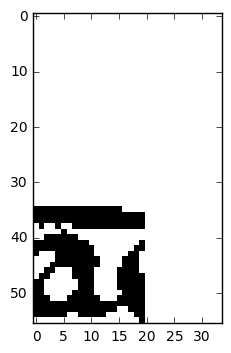

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 85.6647491455%
---
Elapsed time: 0.09413599967956543
Pipeline 2
Bad cut with a confidence of 81.4819335938%
---
Elapsed time: 0.005507230758666992
Pipeline 3
Good cut with a confidence of 85.6647491455% by letter 's_mediana'
Good cut corresponding to letter 's_mediana' with a confidence of 92.9274380207%
Good cut corresponding to letter 'd_mediana' with a confidence of 4.53886575997%
Good cut corresponding to letter 'g' with a confidence of 1.03108687326%
---
Elapsed time: 0.10264849662780762
Pipeline 4
Bad cut with a confidence of 81.4819335938%
---
Elapsed time: 0.0055084228515625


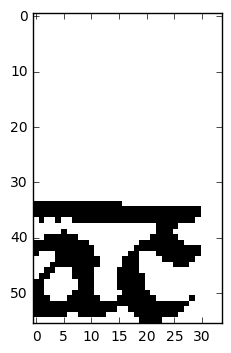

Pipeline 1
Bad cut
---
Elapsed time: 0.09563922882080078
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005506992340087891
Pipeline 3
Bad cut
---
Elapsed time: 0.09113144874572754
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0055084228515625


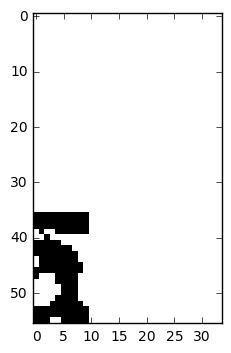

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 50.7674694061%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 71.4619040489%
---
Elapsed time: 0.10815644264221191
Pipeline 2
Bad cut with a confidence of 99.999922514%
---
Elapsed time: 0.005007266998291016
Pipeline 3
Good cut with a confidence of 50.7674694061% by letter 'a'
Good cut with a confidence of 71.4619040489% by letter 's_mediana'
Good cut corresponding to letter 'a' with a confidence of 51.2478590012%
Good cut corresponding to letter 'e' with a confidence of 35.7537001371%
Good cut corresponding to letter 'i' with a confidence of 8.71090367436%
---
Elapsed time: 0.08462190628051758
Pipeline 4
Bad cut with a confidence of 99.999922514%
---
Elapsed time: 0.0055084228515625


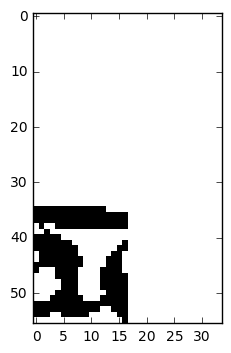

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 97.8783607483%
---
Elapsed time: 0.10415005683898926
Pipeline 2
Bad cut with a confidence of 98.4579265118%
---
Elapsed time: 0.005007266998291016
Pipeline 3
Good cut with a confidence of 97.8783607483% by letter 's_mediana'
Good cut corresponding to letter 's_mediana' with a confidence of 98.5488593578%
Good cut corresponding to letter 'f' with a confidence of 0.544047448784%
Good cut corresponding to letter 's_bassa' with a confidence of 0.268625048921%
---
Elapsed time: 0.0951375961303711
Pipeline 4
Bad cut with a confidence of 98.4579265118%
---
Elapsed time: 0.00600886344909668


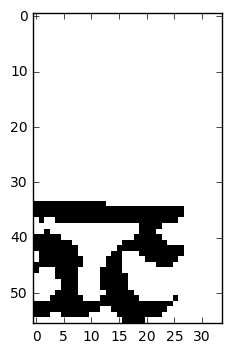

Pipeline 1
Bad cut
---
Elapsed time: 0.11466479301452637
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0055081844329833984
Pipeline 3
Bad cut
---
Elapsed time: 0.08111715316772461
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005507946014404297


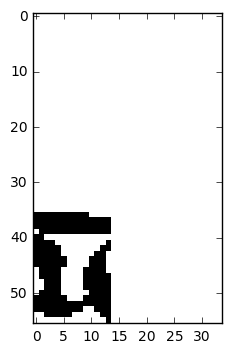

Pipeline 1
Cut 1 has been classified as good corresponding to char 'o' with a confidence of 50.6873846054%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 87.4015688896%
---
Elapsed time: 0.09664034843444824
Pipeline 2
Bad cut with a confidence of 93.2486891747%
---
Elapsed time: 0.005006551742553711
Pipeline 3
Good cut with a confidence of 50.6873846054% by letter 'o'
Good cut with a confidence of 87.4015688896% by letter 's_mediana'
Good cut corresponding to letter 's_mediana' with a confidence of 51.8720030785%
Good cut corresponding to letter 'o' with a confidence of 32.2533428669%
Good cut corresponding to letter 'f' with a confidence of 2.46353112161%
---
Elapsed time: 0.09664034843444824
Pipeline 4
Bad cut with a confidence of 93.2486891747%
---
Elapsed time: 0.005507469177246094


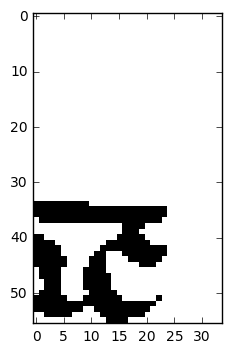

Pipeline 1
Bad cut
---
Elapsed time: 0.1031494140625
Pipeline 2
Bad cut with a confidence of 99.9999701977%
---
Elapsed time: 0.00500798225402832
Pipeline 3
Bad cut
---
Elapsed time: 0.0896296501159668
Pipeline 4
Bad cut with a confidence of 99.9999701977%
---
Elapsed time: 0.005007028579711914


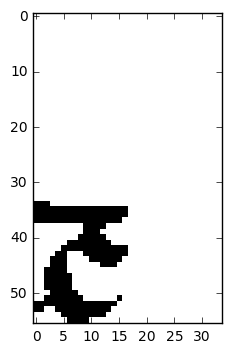

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 65.8551454544%
---
Elapsed time: 0.11817002296447754
Pipeline 2
Bad cut with a confidence of 99.9209225178%
---
Elapsed time: 0.005007028579711914
Pipeline 3
Good cut with a confidence of 65.8551454544% by letter 's_mediana'
Good cut corresponding to letter 'a' with a confidence of 29.026427865%
Good cut corresponding to letter 'd_alta' with a confidence of 23.3107849956%
Good cut corresponding to letter 'g' with a confidence of 18.1170612574%
---
Elapsed time: 0.09814262390136719
Pipeline 4
Bad cut with a confidence of 99.9209225178%
---
Elapsed time: 0.006508827209472656


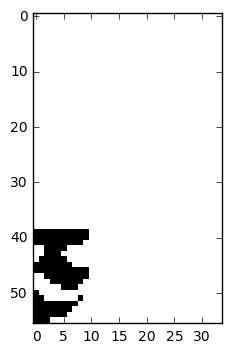

Pipeline 1
Bad cut
---
Elapsed time: 0.11816978454589844
Pipeline 2
Bad cut with a confidence of 99.6944069862%
---
Elapsed time: 0.006509542465209961
Pipeline 3
Bad cut
---
Elapsed time: 0.09714007377624512
Pipeline 4
Bad cut with a confidence of 99.6944069862%
---
Elapsed time: 0.00600886344909668


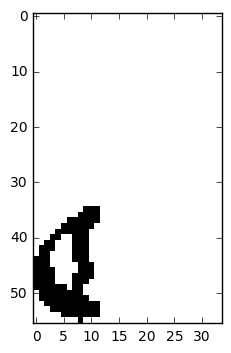

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 78.5577893257%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 52.1737217903%
---
Elapsed time: 0.09213781356811523
Pipeline 2
Bad cut with a confidence of 62.2293174267%
---
Elapsed time: 0.005007266998291016
Pipeline 3
Good cut with a confidence of 78.5577893257% by letter 'e'
Good cut with a confidence of 52.1737217903% by letter 's_mediana'
Good cut corresponding to letter 'e' with a confidence of 85.6598854065%
Good cut corresponding to letter 's_bassa' with a confidence of 7.15013220906%
Good cut corresponding to letter 'o' with a confidence of 5.06254956126%
---
Elapsed time: 0.0951380729675293
Pipeline 4
Bad cut with a confidence of 62.2293174267%
---
Elapsed time: 0.005007743835449219


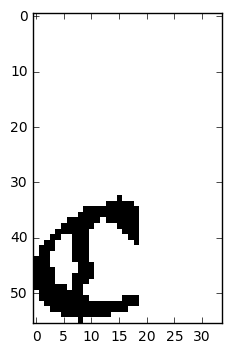

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 86.6546154022%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 60.0675582886%
---
Elapsed time: 0.10114550590515137
Pipeline 2
Good cut corresponding to letter 'e' with a confidence of 71.693611145%
Good cut corresponding to letter 's_bassa' with a confidence of 22.3342016339%
Good cut corresponding to letter 's_alta' with a confidence of 5.45903928578%
---
Elapsed time: 0.011016368865966797
Pipeline 3
Good cut with a confidence of 86.6546154022% by letter 'e'
Good cut with a confidence of 60.0675582886% by letter 's_mediana'
Good cut corresponding to letter 'e' with a confidence of 71.693611145%
Good cut corresponding to letter 's_bassa' with a confidence of 22.3342016339%
Good cut corresponding to letter 's_alta' with a confidence of 5.45903928578%
---
Elapsed time: 0.0945892333984375
Pipeline 4
Good cut with a confidence of 86.6546154022% by letter 'e'

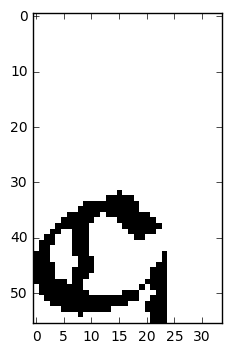

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 91.2056803703%
---
Elapsed time: 0.10264801979064941
Pipeline 2
Good cut corresponding to letter 'e' with a confidence of 84.8328411579%
Good cut corresponding to letter 's_bassa' with a confidence of 14.6172761917%
Good cut corresponding to letter 'a' with a confidence of 0.511258468032%
---
Elapsed time: 0.01051473617553711
Pipeline 3
Good cut with a confidence of 91.2056803703% by letter 'e'
Good cut corresponding to letter 'e' with a confidence of 84.8328411579%
Good cut corresponding to letter 's_bassa' with a confidence of 14.6172761917%
Good cut corresponding to letter 'a' with a confidence of 0.511258468032%
---
Elapsed time: 0.09061765670776367
Pipeline 4
Good cut with a confidence of 91.2056803703% by letter 'e'
---
Elapsed time: 0.0976414680480957


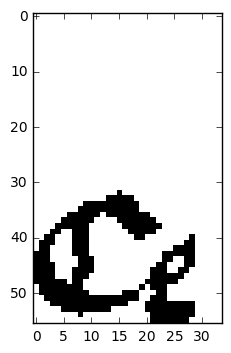

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 62.9460096359%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 88.4967684746%
---
Elapsed time: 0.09864354133605957
Pipeline 2
Bad cut with a confidence of 85.8936667442%
---
Elapsed time: 0.005006313323974609
Pipeline 3
Good cut with a confidence of 62.9460096359% by letter 'e'
Good cut with a confidence of 88.4967684746% by letter 's_mediana'
Good cut corresponding to letter 'e' with a confidence of 61.842238903%
Good cut corresponding to letter 'a' with a confidence of 15.033942461%
Good cut corresponding to letter 'g' with a confidence of 7.65841156244%
---
Elapsed time: 0.09358024597167969
Pipeline 4
Bad cut with a confidence of 85.8936667442%
---
Elapsed time: 0.0055084228515625


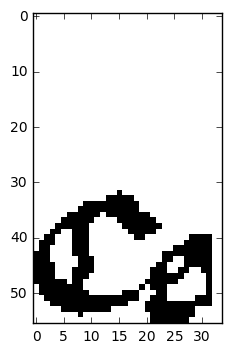

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 87.6769721508%
---
Elapsed time: 0.09263420104980469
Pipeline 2
Bad cut with a confidence of 99.9999642372%
---
Elapsed time: 0.006509542465209961
Pipeline 3
Good cut with a confidence of 87.6769721508% by letter 's_mediana'
Good cut corresponding to letter 'e' with a confidence of 35.4587614536%
Good cut corresponding to letter 'g' with a confidence of 25.6311506033%
Good cut corresponding to letter 'a' with a confidence of 24.6369093657%
---
Elapsed time: 0.10264825820922852
Pipeline 4
Bad cut with a confidence of 99.9999642372%
---
Elapsed time: 0.006510496139526367


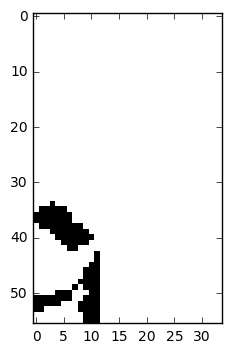

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 72.4145889282%
---
Elapsed time: 0.0976405143737793
Pipeline 2
Bad cut with a confidence of 99.9608039856%
---
Elapsed time: 0.006009340286254883
Pipeline 3
Good cut with a confidence of 72.4145889282% by letter 's_mediana'
Good cut corresponding to letter 'a' with a confidence of 41.4603710175%
Good cut corresponding to letter 'c' with a confidence of 21.1409002542%
Good cut corresponding to letter 'd_alta' with a confidence of 18.1320279837%
---
Elapsed time: 0.09163570404052734
Pipeline 4
Bad cut with a confidence of 99.9608039856%
---
Elapsed time: 0.005508899688720703


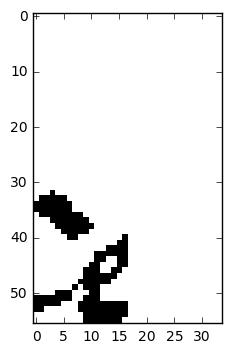

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 98.3559787273%
---
Elapsed time: 0.09313344955444336
Pipeline 2
Bad cut with a confidence of 99.9922454357%
---
Elapsed time: 0.005507946014404297
Pipeline 3
Good cut with a confidence of 98.3559787273% by letter 's_mediana'
Good cut corresponding to letter 's_bassa' with a confidence of 60.3106617928%
Good cut corresponding to letter 'd_alta' with a confidence of 29.613545537%
Good cut corresponding to letter 'a' with a confidence of 8.84821563959%
---
Elapsed time: 0.08812761306762695
Pipeline 4
Bad cut with a confidence of 99.9922454357%
---
Elapsed time: 0.005007505416870117


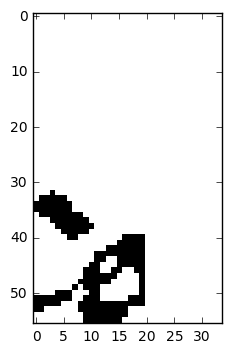

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 69.8100328445%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 95.3231215477%
---
Elapsed time: 0.09263300895690918
Pipeline 2
Bad cut with a confidence of 96.6777324677%
---
Elapsed time: 0.0055081844329833984
Pipeline 3
Good cut with a confidence of 69.8100328445% by letter 'a'
Good cut with a confidence of 95.3231215477% by letter 's_mediana'
Good cut corresponding to letter 'a' with a confidence of 49.2538154125%
Good cut corresponding to letter 'd_alta' with a confidence of 39.6818846464%
Good cut corresponding to letter 's_bassa' with a confidence of 10.6039896607%
---
Elapsed time: 0.09013080596923828
Pipeline 4
Bad cut with a confidence of 96.6777324677%
---
Elapsed time: 0.0050067901611328125


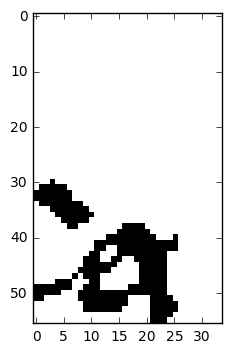

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.1631507874%
---
Elapsed time: 0.09163212776184082
Pipeline 2
Bad cut with a confidence of 54.4400811195%
---
Elapsed time: 0.005008220672607422
Pipeline 3
Good cut with a confidence of 99.1631507874% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 92.1103358269%
Good cut corresponding to letter 's_mediana' with a confidence of 7.50738978386%
Good cut corresponding to letter 'a' with a confidence of 0.274638924748%
---
Elapsed time: 0.09012961387634277
Pipeline 4
Bad cut with a confidence of 54.4400811195%
---
Elapsed time: 0.006009578704833984


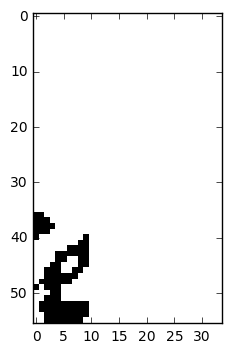

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 88.3709311485%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 57.8128993511%
---
Elapsed time: 0.09413433074951172
Pipeline 2
Bad cut with a confidence of 99.8422801495%
---
Elapsed time: 0.0055081844329833984
Pipeline 3
Good cut with a confidence of 88.3709311485% by letter 'c'
Good cut with a confidence of 57.8128993511% by letter 's_mediana'
Good cut corresponding to letter 'c' with a confidence of 99.9456048012%
Good cut corresponding to letter 'e' with a confidence of 0.0320599268889%
Good cut corresponding to letter 's_bassa' with a confidence of 0.0132136425236%
---
Elapsed time: 0.08712577819824219
Pipeline 4
Bad cut with a confidence of 99.8422801495%
---
Elapsed time: 0.005007028579711914


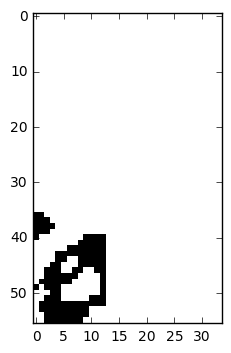

Pipeline 1
Bad cut
---
Elapsed time: 0.09513711929321289
Pipeline 2
Bad cut with a confidence of 92.2971725464%
---
Elapsed time: 0.005007028579711914
Pipeline 3
Bad cut
---
Elapsed time: 0.08662605285644531
Pipeline 4
Bad cut with a confidence of 92.2971725464%
---
Elapsed time: 0.005507946014404297


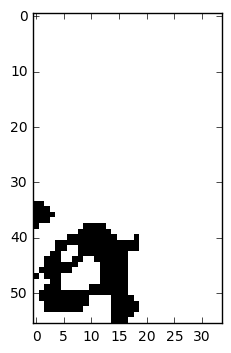

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 92.8989768028%
---
Elapsed time: 0.09513664245605469
Pipeline 2
Good cut corresponding to letter 'o' with a confidence of 31.2739551067%
Good cut corresponding to letter 'a' with a confidence of 31.0680419207%
Good cut corresponding to letter 's_mediana' with a confidence of 24.7643470764%
---
Elapsed time: 0.011017560958862305
Pipeline 3
Good cut with a confidence of 92.8989768028% by letter 's_mediana'
Good cut corresponding to letter 'o' with a confidence of 31.2739551067%
Good cut corresponding to letter 'a' with a confidence of 31.0680419207%
Good cut corresponding to letter 's_mediana' with a confidence of 24.7643470764%
---
Elapsed time: 0.08600449562072754
Pipeline 4
Good cut with a confidence of 92.8989768028% by letter 's_mediana'
---
Elapsed time: 0.09864330291748047


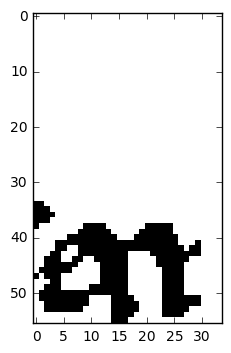

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 75.0418782234%
---
Elapsed time: 0.10264706611633301
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005508899688720703
Pipeline 3
Good cut with a confidence of 75.0418782234% by letter 's_mediana'
Good cut corresponding to letter 'm' with a confidence of 82.3098301888%
Good cut corresponding to letter 'd_mediana' with a confidence of 10.4553423822%
Good cut corresponding to letter 'e' with a confidence of 5.54954521358%
---
Elapsed time: 0.08812689781188965
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005007505416870117


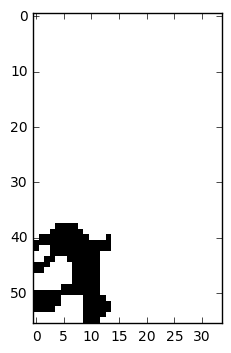

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 56.2637805939%
Cut 1 has been classified as good corresponding to char 'o' with a confidence of 80.2462875843%
---
Elapsed time: 0.09113216400146484
Pipeline 2
Bad cut with a confidence of 58.8262736797%
---
Elapsed time: 0.004506587982177734
Pipeline 3
Good cut with a confidence of 56.2637805939% by letter 'a'
Good cut with a confidence of 80.2462875843% by letter 'o'
Good cut corresponding to letter 'a' with a confidence of 83.2654595375%
Good cut corresponding to letter 'o' with a confidence of 16.1460623145%
Good cut corresponding to letter 'e' with a confidence of 0.444103823975%
---
Elapsed time: 0.08948326110839844
Pipeline 4
Bad cut with a confidence of 58.8262736797%
---
Elapsed time: 0.006008625030517578


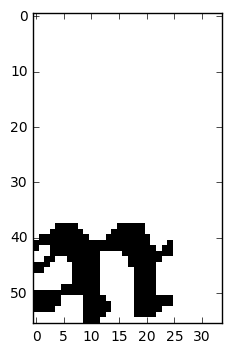

Pipeline 1
Bad cut
---
Elapsed time: 0.08962893486022949
Pipeline 2
Bad cut with a confidence of 99.8021900654%
---
Elapsed time: 0.005507946014404297
Pipeline 3
Bad cut
---
Elapsed time: 0.08862805366516113
Pipeline 4
Bad cut with a confidence of 99.8021900654%
---
Elapsed time: 0.005507946014404297


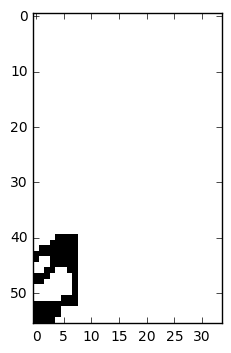

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 69.3239510059%
---
Elapsed time: 0.10515284538269043
Pipeline 2
Bad cut with a confidence of 83.2175135612%
---
Elapsed time: 0.0060083866119384766
Pipeline 3
Good cut with a confidence of 69.3239510059% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 96.3730335236%
Good cut corresponding to letter 'e' with a confidence of 2.18799598515%
Good cut corresponding to letter 'a' with a confidence of 1.37596456334%
---
Elapsed time: 0.11366462707519531
Pipeline 4
Bad cut with a confidence of 83.2175135612%
---
Elapsed time: 0.0070095062255859375


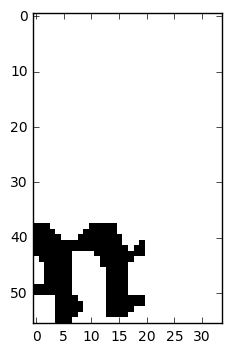

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 72.9630112648%
---
Elapsed time: 0.10615372657775879
Pipeline 2
Bad cut with a confidence of 50.51664114%
---
Elapsed time: 0.008512258529663086
Pipeline 3
Good cut with a confidence of 72.9630112648% by letter 'n'
Good cut corresponding to letter 'n' with a confidence of 99.7142136097%
Good cut corresponding to letter 'a' with a confidence of 0.112856947817%
Good cut corresponding to letter 'o' with a confidence of 0.0820893037599%
---
Elapsed time: 0.0921335220336914
Pipeline 4
Bad cut with a confidence of 50.51664114%
---
Elapsed time: 0.006509065628051758


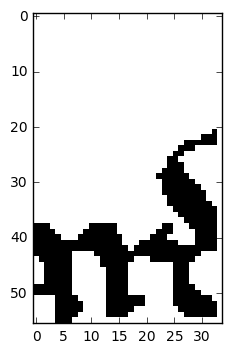

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.7608006001%
---
Elapsed time: 0.10114574432373047
Pipeline 2
Bad cut with a confidence of 99.9971568584%
---
Elapsed time: 0.006509542465209961
Pipeline 3
Good cut with a confidence of 99.7608006001% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 100.0%
Good cut corresponding to letter 'b' with a confidence of 2.25997638381e-06%
Good cut corresponding to letter 'e' with a confidence of 1.05493458413e-07%
---
Elapsed time: 0.09263372421264648
Pipeline 4
Bad cut with a confidence of 99.9971568584%
---
Elapsed time: 0.005507946014404297


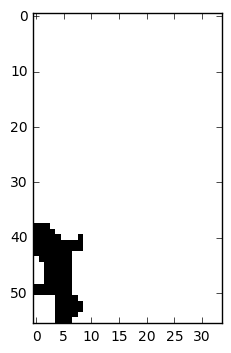

Pipeline 1
Bad cut
---
Elapsed time: 0.10263776779174805
Pipeline 2
Bad cut with a confidence of 99.9759018421%
---
Elapsed time: 0.006008148193359375
Pipeline 3
Bad cut
---
Elapsed time: 0.09363579750061035
Pipeline 4
Bad cut with a confidence of 99.9759018421%
---
Elapsed time: 0.006009101867675781


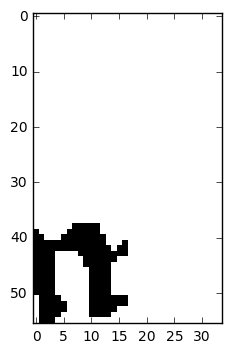

Pipeline 1
Cut 1 has been classified as good corresponding to char 'o' with a confidence of 92.1360611916%
---
Elapsed time: 0.10665440559387207
Pipeline 2
Good cut corresponding to letter 'o' with a confidence of 97.7522492409%
Good cut corresponding to letter 'n' with a confidence of 1.75145380199%
Good cut corresponding to letter 'a' with a confidence of 0.289734639227%
---
Elapsed time: 0.011516332626342773
Pipeline 3
Good cut with a confidence of 92.1360611916% by letter 'o'
Good cut corresponding to letter 'o' with a confidence of 97.7522492409%
Good cut corresponding to letter 'n' with a confidence of 1.75145380199%
Good cut corresponding to letter 'a' with a confidence of 0.289734639227%
---
Elapsed time: 0.09864282608032227
Pipeline 4
Good cut with a confidence of 92.1360611916% by letter 'o'
---
Elapsed time: 0.09714150428771973


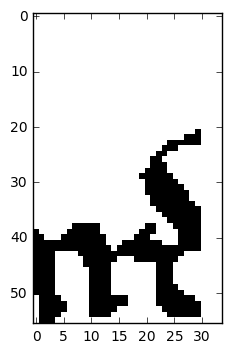

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.7362315655%
---
Elapsed time: 0.11917304992675781
Pipeline 2
Bad cut with a confidence of 99.9794006348%
---
Elapsed time: 0.006509304046630859
Pipeline 3
Good cut with a confidence of 99.7362315655% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9999821186%
Good cut corresponding to letter 'f' with a confidence of 1.01510110539e-05%
Good cut corresponding to letter 'b' with a confidence of 5.64796671654e-06%
---
Elapsed time: 0.10415029525756836
Pipeline 4
Bad cut with a confidence of 99.9794006348%
---
Elapsed time: 0.007511615753173828


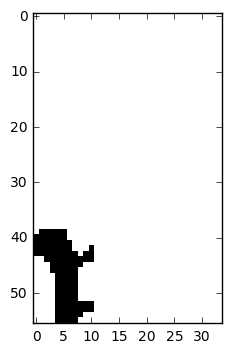

Pipeline 1
Bad cut
---
Elapsed time: 0.10865640640258789
Pipeline 2
Bad cut with a confidence of 99.0374386311%
---
Elapsed time: 0.008512496948242188
Pipeline 3
Bad cut
---
Elapsed time: 0.08762669563293457
Pipeline 4
Bad cut with a confidence of 99.0374386311%
---
Elapsed time: 0.0060083866119384766


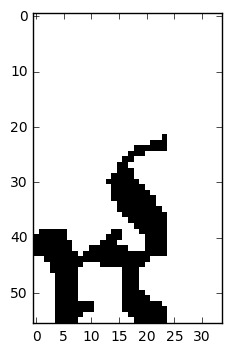

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.4866371155%
---
Elapsed time: 0.0921332836151123
Pipeline 2
Bad cut with a confidence of 99.9619305134%
---
Elapsed time: 0.0060079097747802734
Pipeline 3
Good cut with a confidence of 99.4866371155% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9883294106%
Good cut corresponding to letter 'b' with a confidence of 0.0072355629527%
Good cut corresponding to letter 'f' with a confidence of 0.00401898214477%
---
Elapsed time: 0.09764313697814941
Pipeline 4
Bad cut with a confidence of 99.9619305134%
---
Elapsed time: 0.0055081844329833984


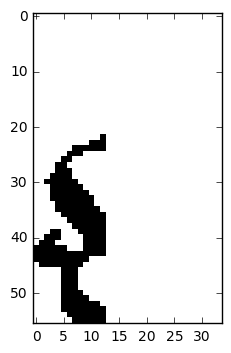

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.2093265057%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 80.941593647%
Cut 1 has been classified as good corresponding to char 's_bassa' with a confidence of 63.4239137173%
---
Elapsed time: 0.0896298885345459
Pipeline 2
Good cut corresponding to letter 's_bassa' with a confidence of 88.1004929543%
Good cut corresponding to letter 'd_alta' with a confidence of 11.8994787335%
Good cut corresponding to letter 'e' with a confidence of 2.34763618323e-05%
---
Elapsed time: 0.011517763137817383
Pipeline 3
Good cut with a confidence of 99.2093265057% by letter 's_mediana'
Good cut with a confidence of 80.941593647% by letter 'd_alta'
Good cut with a confidence of 63.4239137173% by letter 's_bassa'
Good cut corresponding to letter 's_bassa' with a confidence of 88.1004929543%
Good cut corresponding to letter 'd_alta' with a confidence of 11.8994787335%

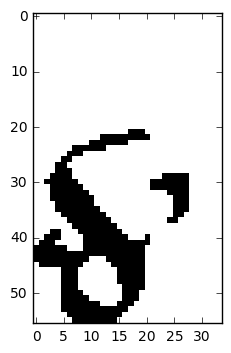

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.9127984047%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 72.0054328442%
---
Elapsed time: 0.10415029525756836
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 99.996727705%
Good cut corresponding to letter 's_bassa' with a confidence of 0.00209649751923%
Good cut corresponding to letter 'b' with a confidence of 0.00069999077823%
---
Elapsed time: 0.010515213012695312
Pipeline 3
Good cut with a confidence of 99.9127984047% by letter 's_mediana'
Good cut with a confidence of 72.0054328442% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.996727705%
Good cut corresponding to letter 's_bassa' with a confidence of 0.00209649751923%
Good cut corresponding to letter 'b' with a confidence of 0.00069999077823%
---
Elapsed time: 0.08862829208374023
Pipeline 4
Good cut with a confidence of 99.91

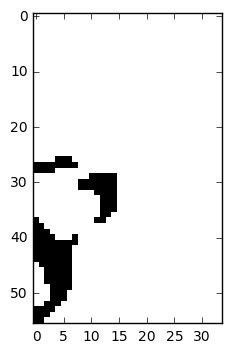

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 87.8626704216%
---
Elapsed time: 0.1136629581451416
Pipeline 2
Bad cut with a confidence of 99.9998390675%
---
Elapsed time: 0.006009101867675781
Pipeline 3
Good cut with a confidence of 87.8626704216% by letter 's_mediana'
Good cut corresponding to letter 'l' with a confidence of 57.3487818241%
Good cut corresponding to letter 's_bassa' with a confidence of 33.0120384693%
Good cut corresponding to letter 'd_alta' with a confidence of 5.67945614457%
---
Elapsed time: 0.09814190864562988
Pipeline 4
Bad cut with a confidence of 99.9998390675%
---
Elapsed time: 0.0060083866119384766


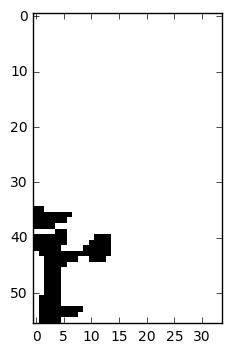

Pipeline 1
Cut 1 has been classified as good corresponding to char 'r' with a confidence of 98.7077116966%
---
Elapsed time: 0.10064506530761719
Pipeline 2
Good cut corresponding to letter 'r' with a confidence of 95.9815680981%
Good cut corresponding to letter 't' with a confidence of 3.99000905454%
Good cut corresponding to letter 'i' with a confidence of 0.0135930691613%
---
Elapsed time: 0.011517047882080078
Pipeline 3
Good cut with a confidence of 98.7077116966% by letter 'r'
Good cut corresponding to letter 'r' with a confidence of 95.9815680981%
Good cut corresponding to letter 't' with a confidence of 3.99000905454%
Good cut corresponding to letter 'i' with a confidence of 0.0135930691613%
---
Elapsed time: 0.09313440322875977
Pipeline 4
Good cut with a confidence of 98.7077116966% by letter 'r'
---
Elapsed time: 0.10214805603027344


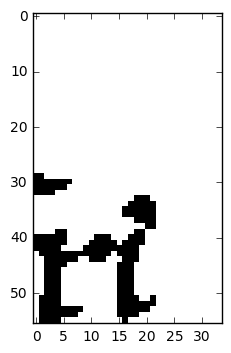

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.9325454235%
---
Elapsed time: 0.10865664482116699
Pipeline 2
Bad cut with a confidence of 95.1574623585%
---
Elapsed time: 0.006009101867675781
Pipeline 3
Good cut with a confidence of 99.9325454235% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 76.4525830746%
Good cut corresponding to letter 'd_alta' with a confidence of 15.0299459696%
Good cut corresponding to letter 'b' with a confidence of 7.81185030937%
---
Elapsed time: 0.09663939476013184
Pipeline 4
Bad cut with a confidence of 95.1574623585%
---
Elapsed time: 0.007010221481323242


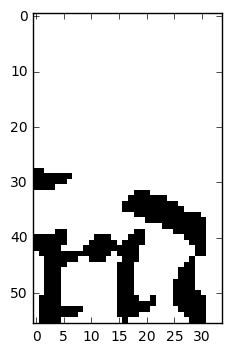

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.5843529701%
---
Elapsed time: 0.09613823890686035
Pipeline 2
Bad cut with a confidence of 99.9950587749%
---
Elapsed time: 0.006009340286254883
Pipeline 3
Good cut with a confidence of 99.5843529701% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.1520404816%
Good cut corresponding to letter 'b' with a confidence of 0.527491467074%
Good cut corresponding to letter 's_mediana' with a confidence of 0.113337591756%
---
Elapsed time: 0.09866642951965332
Pipeline 4
Bad cut with a confidence of 99.9950587749%
---
Elapsed time: 0.005506753921508789


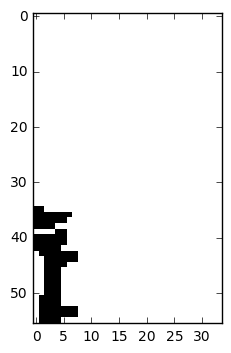

Pipeline 1
Bad cut
---
Elapsed time: 0.10565352439880371
Pipeline 2
Bad cut with a confidence of 97.6052284241%
---
Elapsed time: 0.006008148193359375
Pipeline 3
Bad cut
---
Elapsed time: 0.08862805366516113
Pipeline 4
Bad cut with a confidence of 97.6052284241%
---
Elapsed time: 0.005007028579711914


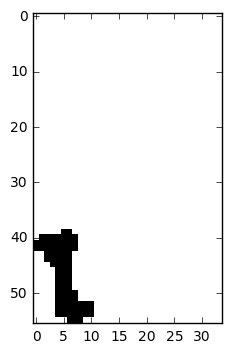

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 92.207890749%
---
Elapsed time: 0.10915756225585938
Pipeline 2
Bad cut with a confidence of 55.2363872528%
---
Elapsed time: 0.0055081844329833984
Pipeline 3
Good cut with a confidence of 92.207890749% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9877154827%
Good cut corresponding to letter 't' with a confidence of 0.011917478696%
Good cut corresponding to letter 'l' with a confidence of 0.000291839705824%
---
Elapsed time: 0.09463691711425781
Pipeline 4
Bad cut with a confidence of 55.2363872528%
---
Elapsed time: 0.0055081844329833984


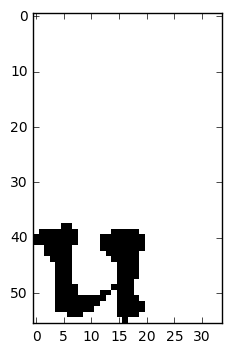

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 71.1799383163%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 88.9712929726%
---
Elapsed time: 0.13219141960144043
Pipeline 2
Good cut corresponding to letter 'u' with a confidence of 99.9557197094%
Good cut corresponding to letter 'n' with a confidence of 0.0441779673565%
Good cut corresponding to letter 'r' with a confidence of 5.40087739864e-05%
---
Elapsed time: 0.014020204544067383
Pipeline 3
Good cut with a confidence of 71.1799383163% by letter 'i'
Good cut with a confidence of 88.9712929726% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 99.9557197094%
Good cut corresponding to letter 'n' with a confidence of 0.0441779673565%
Good cut corresponding to letter 'r' with a confidence of 5.40087739864e-05%
---
Elapsed time: 0.12167572975158691
Pipeline 4
Good cut with a confidence of 71.1799383163% by letter 'i'
Good cut with a confid

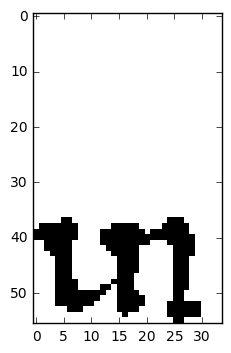

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 55.8858692646%
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 69.7175562382%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 51.4569342136%
---
Elapsed time: 0.09613871574401855
Pipeline 2
Good cut corresponding to letter 'm' with a confidence of 99.9971091747%
Good cut corresponding to letter 'n' with a confidence of 0.00286350368697%
Good cut corresponding to letter 'u' with a confidence of 2.31339456036e-05%
---
Elapsed time: 0.011017084121704102
Pipeline 3
Good cut with a confidence of 55.8858692646% by letter 'i'
Good cut with a confidence of 69.7175562382% by letter 'm'
Good cut with a confidence of 51.4569342136% by letter 'u'
Good cut corresponding to letter 'm' with a confidence of 99.9971091747%
Good cut corresponding to letter 'n' with a confidence of 0.00286350368697%
Good cut corresponding to letter 'u' with a confid

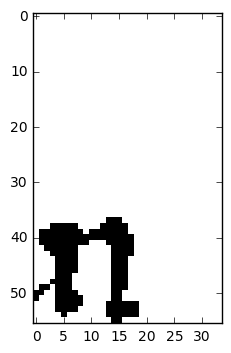

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 98.794901371%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 51.2238740921%
---
Elapsed time: 0.09563779830932617
Pipeline 2
Good cut corresponding to letter 'n' with a confidence of 99.9204993248%
Good cut corresponding to letter 'u' with a confidence of 0.0790561898611%
Good cut corresponding to letter 'o' with a confidence of 0.000326552549268%
---
Elapsed time: 0.011017084121704102
Pipeline 3
Good cut with a confidence of 98.794901371% by letter 'n'
Good cut with a confidence of 51.2238740921% by letter 'u'
Good cut corresponding to letter 'n' with a confidence of 99.9204993248%
Good cut corresponding to letter 'u' with a confidence of 0.0790561898611%
Good cut corresponding to letter 'o' with a confidence of 0.000326552549268%
---
Elapsed time: 0.09063172340393066
Pipeline 4
Good cut with a confidence of 98.794901371% by letter 'n'
Good cut with a confidenc

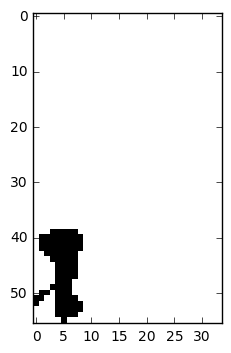

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 89.4575893879%
---
Elapsed time: 0.10765480995178223
Pipeline 2
Bad cut with a confidence of 79.8146605492%
---
Elapsed time: 0.005507946014404297
Pipeline 3
Good cut with a confidence of 89.4575893879% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9990165234%
Good cut corresponding to letter 't' with a confidence of 0.00079235078374%
Good cut corresponding to letter 'a' with a confidence of 0.000120875370158%
---
Elapsed time: 0.08912920951843262
Pipeline 4
Bad cut with a confidence of 79.8146605492%
---
Elapsed time: 0.005507946014404297


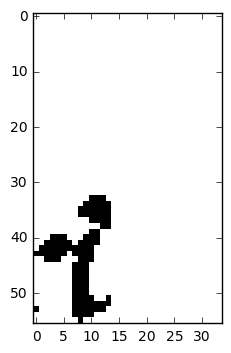

Pipeline 1
Bad cut
---
Elapsed time: 0.10415005683898926
Pipeline 2
Bad cut with a confidence of 98.1995940208%
---
Elapsed time: 0.007010459899902344
Pipeline 3
Bad cut
---
Elapsed time: 0.09163236618041992
Pipeline 4
Bad cut with a confidence of 98.1995940208%
---
Elapsed time: 0.005507707595825195


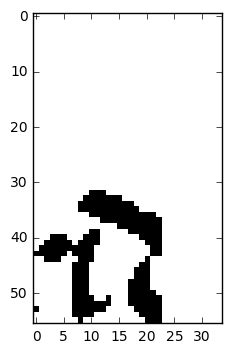

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 98.0617642403%
---
Elapsed time: 0.09613871574401855
Pipeline 2
Bad cut with a confidence of 99.1600990295%
---
Elapsed time: 0.006008148193359375
Pipeline 3
Good cut with a confidence of 98.0617642403% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 95.779055357%
Good cut corresponding to letter 'd_mediana' with a confidence of 1.83333419263%
Good cut corresponding to letter 's_mediana' with a confidence of 1.64090972394%
---
Elapsed time: 0.10014510154724121
Pipeline 4
Bad cut with a confidence of 99.1600990295%
---
Elapsed time: 0.006509304046630859


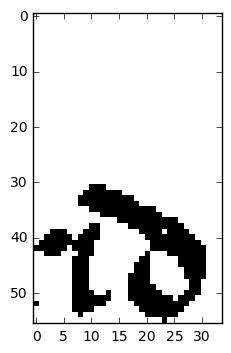

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.7805118561%
---
Elapsed time: 0.09915614128112793
Pipeline 2
Bad cut with a confidence of 99.9998271465%
---
Elapsed time: 0.006008625030517578
Pipeline 3
Good cut with a confidence of 99.7805118561% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 97.9616463184%
Good cut corresponding to letter 'd_mediana' with a confidence of 2.03781370074%
Good cut corresponding to letter 's_mediana' with a confidence of 0.00049404056881%
---
Elapsed time: 0.09463667869567871
Pipeline 4
Bad cut with a confidence of 99.9998271465%
---
Elapsed time: 0.0055081844329833984


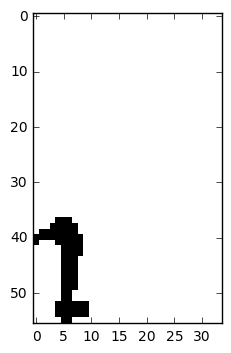

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 82.0454001427%
---
Elapsed time: 0.09414100646972656
Pipeline 2
Good cut corresponding to letter 'i' with a confidence of 99.9777913094%
Good cut corresponding to letter 'l' with a confidence of 0.0132055894937%
Good cut corresponding to letter 't' with a confidence of 0.00589928822592%
---
Elapsed time: 0.011516332626342773
Pipeline 3
Good cut with a confidence of 82.0454001427% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9777913094%
Good cut corresponding to letter 'l' with a confidence of 0.0132055894937%
Good cut corresponding to letter 't' with a confidence of 0.00589928822592%
---
Elapsed time: 0.09113168716430664
Pipeline 4
Good cut with a confidence of 82.0454001427% by letter 'i'
---
Elapsed time: 0.09964418411254883


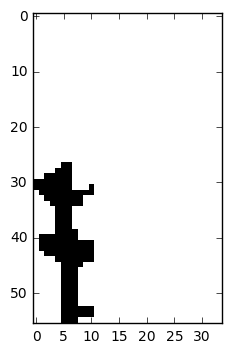

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 96.6057300568%
---
Elapsed time: 0.11066055297851562
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0050067901611328125
Pipeline 3
Good cut with a confidence of 96.6057300568% by letter 's_mediana'
Good cut corresponding to letter 'l' with a confidence of 99.6514201164%
Good cut corresponding to letter 's_alta' with a confidence of 0.343650532886%
Good cut corresponding to letter 'p' with a confidence of 0.00293437424261%
---
Elapsed time: 0.09013128280639648
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005006551742553711


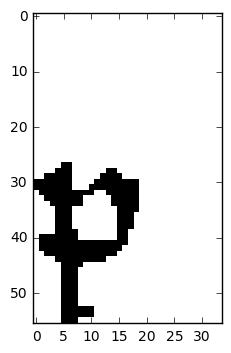

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 72.4262297153%
Cut 1 has been classified as good corresponding to char 'h' with a confidence of 70.9034860134%
Cut 1 has been classified as good corresponding to char 'p' with a confidence of 99.9449133873%
---
Elapsed time: 0.09664082527160645
Pipeline 2
Good cut corresponding to letter 'p' with a confidence of 100.0%
Good cut corresponding to letter 's_alta' with a confidence of 5.9243291696e-10%
Good cut corresponding to letter 'f' with a confidence of 3.30786884429e-11%
---
Elapsed time: 0.012518167495727539
Pipeline 3
Good cut with a confidence of 72.4262297153% by letter 's_mediana'
Good cut with a confidence of 70.9034860134% by letter 'h'
Good cut with a confidence of 99.9449133873% by letter 'p'
Good cut corresponding to letter 'p' with a confidence of 100.0%
Good cut corresponding to letter 's_alta' with a confidence of 5.9243291696e-10%
Good cut corresponding to letter 'f' wit

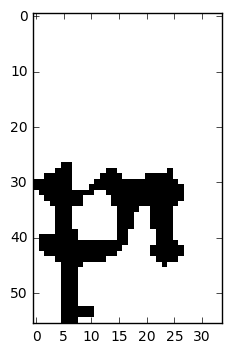

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 73.3964443207%
---
Elapsed time: 0.11266279220581055
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005007266998291016
Pipeline 3
Good cut with a confidence of 73.3964443207% by letter 's_mediana'
Good cut corresponding to letter 'p' with a confidence of 99.9999880791%
Good cut corresponding to letter 'g' with a confidence of 9.27148633423e-06%
Good cut corresponding to letter 'q' with a confidence of 2.04984362817e-08%
---
Elapsed time: 0.0896296501159668
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.006509542465209961


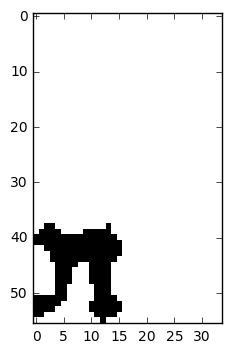

Pipeline 1
Bad cut
---
Elapsed time: 0.09914302825927734
Pipeline 2
Good cut corresponding to letter 'a' with a confidence of 60.7241809368%
Good cut corresponding to letter 'e' with a confidence of 31.5345793962%
Good cut corresponding to letter 'n' with a confidence of 7.10089057684%
---
Elapsed time: 0.012517452239990234
Pipeline 3
Bad cut
---
Elapsed time: 0.08809375762939453
Pipeline 4
---
Elapsed time: 0.09663915634155273


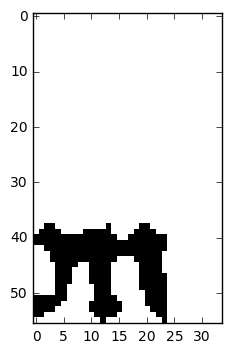

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 59.2548787594%
---
Elapsed time: 0.09613800048828125
Pipeline 2
Bad cut with a confidence of 96.7108428478%
---
Elapsed time: 0.006510019302368164
Pipeline 3
Good cut with a confidence of 59.2548787594% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 99.9550223351%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.0441831361968%
Good cut corresponding to letter 'e' with a confidence of 0.000628609996056%
---
Elapsed time: 0.09864258766174316
Pipeline 4
Bad cut with a confidence of 96.7108428478%
---
Elapsed time: 0.005007505416870117


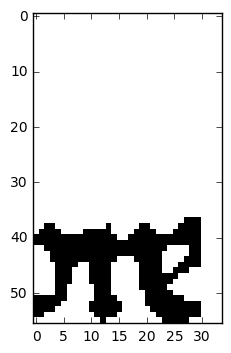

Pipeline 1
Bad cut
---
Elapsed time: 0.09263277053833008
Pipeline 2
Bad cut with a confidence of 94.6817040443%
---
Elapsed time: 0.00500798225402832
Pipeline 3
Bad cut
---
Elapsed time: 0.08362102508544922
Pipeline 4
Bad cut with a confidence of 94.6817040443%
---
Elapsed time: 0.005006551742553711


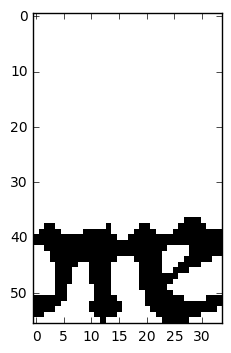

Pipeline 1
Bad cut
---
Elapsed time: 0.09756016731262207
Pipeline 2
Bad cut with a confidence of 99.858725071%
---
Elapsed time: 0.005006313323974609
Pipeline 3
Bad cut
---
Elapsed time: 0.0841224193572998
Pipeline 4
Bad cut with a confidence of 99.858725071%
---
Elapsed time: 0.005506992340087891


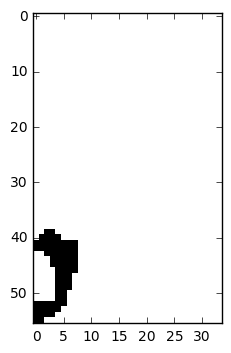

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 76.119852066%
---
Elapsed time: 0.09864258766174316
Pipeline 2
Bad cut with a confidence of 97.927159071%
---
Elapsed time: 0.005006551742553711
Pipeline 3
Good cut with a confidence of 76.119852066% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9962508678%
Good cut corresponding to letter 'r' with a confidence of 0.00145910253195%
Good cut corresponding to letter 'a' with a confidence of 0.00131572714963%
---
Elapsed time: 0.09435081481933594
Pipeline 4
Bad cut with a confidence of 97.927159071%
---
Elapsed time: 0.005007028579711914


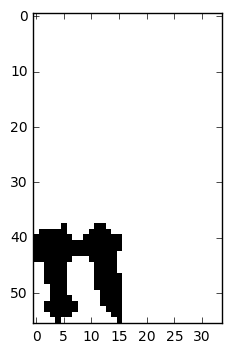

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 81.3542962074%
---
Elapsed time: 0.09213376045227051
Pipeline 2
Good cut corresponding to letter 'n' with a confidence of 99.9965846539%
Good cut corresponding to letter 'o' with a confidence of 0.00228755088756%
Good cut corresponding to letter 'u' with a confidence of 0.000856413134898%
---
Elapsed time: 0.011016130447387695
Pipeline 3
Good cut with a confidence of 81.3542962074% by letter 'n'
Good cut corresponding to letter 'n' with a confidence of 99.9965846539%
Good cut corresponding to letter 'o' with a confidence of 0.00228755088756%
Good cut corresponding to letter 'u' with a confidence of 0.000856413134898%
---
Elapsed time: 0.08862757682800293
Pipeline 4
Good cut with a confidence of 81.3542962074% by letter 'n'
---
Elapsed time: 0.10014557838439941


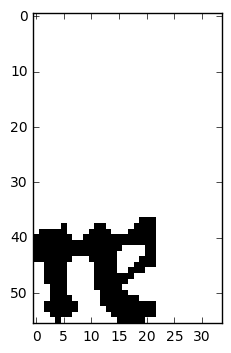

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 58.8590323925%
---
Elapsed time: 0.10915708541870117
Pipeline 2
Bad cut with a confidence of 90.876853466%
---
Elapsed time: 0.005507707595825195
Pipeline 3
Good cut with a confidence of 58.8590323925% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 99.9164760113%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.0790432270151%
Good cut corresponding to letter 'a' with a confidence of 0.00347441600752%
---
Elapsed time: 0.08860969543457031
Pipeline 4
Bad cut with a confidence of 90.876853466%
---
Elapsed time: 0.006008625030517578


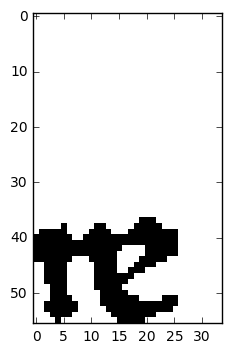

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 59.7999334335%
---
Elapsed time: 0.10515332221984863
Pipeline 2
Bad cut with a confidence of 99.2502808571%
---
Elapsed time: 0.006008625030517578
Pipeline 3
Good cut with a confidence of 59.7999334335% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 99.9834179878%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.0159870091011%
Good cut corresponding to letter 'e' with a confidence of 0.000597537746216%
---
Elapsed time: 0.0951375961303711
Pipeline 4
Bad cut with a confidence of 99.2502808571%
---
Elapsed time: 0.00600886344909668


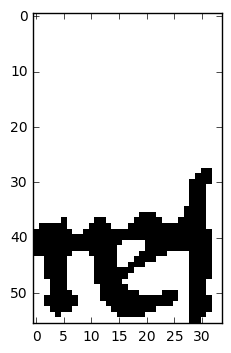

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 72.4643647671%
---
Elapsed time: 0.09864282608032227
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.006509542465209961
Pipeline 3
Good cut with a confidence of 72.4643647671% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 69.9189066887%
Good cut corresponding to letter 'b' with a confidence of 20.7163602114%
Good cut corresponding to letter 'm' with a confidence of 8.84409844875%
---
Elapsed time: 0.0976407527923584
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0055081844329833984


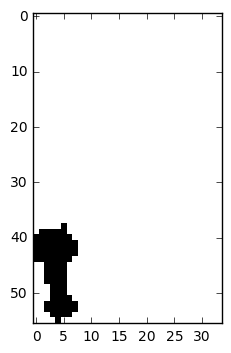

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 79.257774353%
---
Elapsed time: 0.09286212921142578
Pipeline 2
Bad cut with a confidence of 99.8948395252%
---
Elapsed time: 0.00500798225402832
Pipeline 3
Good cut with a confidence of 79.257774353% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9800086021%
Good cut corresponding to letter 't' with a confidence of 0.0153752145707%
Good cut corresponding to letter 'a' with a confidence of 0.00332062372763%
---
Elapsed time: 0.09113073348999023
Pipeline 4
Bad cut with a confidence of 99.8948395252%
---
Elapsed time: 0.005007028579711914


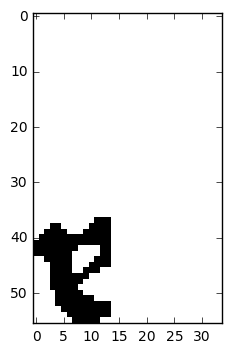

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 74.6559798717%
---
Elapsed time: 0.09413599967956543
Pipeline 2
Good cut corresponding to letter 'e' with a confidence of 99.9718010426%
Good cut corresponding to letter 'r' with a confidence of 0.0233513768762%
Good cut corresponding to letter 'a' with a confidence of 0.00422246048402%
---
Elapsed time: 0.011516094207763672
Pipeline 3
Good cut with a confidence of 74.6559798717% by letter 'e'
Good cut corresponding to letter 'e' with a confidence of 99.9718010426%
Good cut corresponding to letter 'r' with a confidence of 0.0233513768762%
Good cut corresponding to letter 'a' with a confidence of 0.00422246048402%
---
Elapsed time: 0.1006467342376709
Pipeline 4
Good cut with a confidence of 74.6559798717% by letter 'e'
---
Elapsed time: 0.10615229606628418


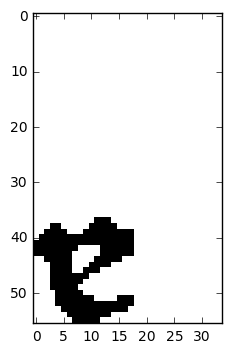

Pipeline 1
Cut 1 has been classified as good corresponding to char 'e' with a confidence of 92.02876091%
---
Elapsed time: 0.10465025901794434
Pipeline 2
Good cut corresponding to letter 'e' with a confidence of 99.9994874001%
Good cut corresponding to letter 'a' with a confidence of 0.000507317145093%
Good cut corresponding to letter 'n' with a confidence of 7.50235784608e-06%
---
Elapsed time: 0.012018203735351562
Pipeline 3
Good cut with a confidence of 92.02876091% by letter 'e'
Good cut corresponding to letter 'e' with a confidence of 99.9994874001%
Good cut corresponding to letter 'a' with a confidence of 0.000507317145093%
Good cut corresponding to letter 'n' with a confidence of 7.50235784608e-06%
---
Elapsed time: 0.08862757682800293
Pipeline 4
Good cut with a confidence of 92.02876091% by letter 'e'
---
Elapsed time: 0.09663534164428711


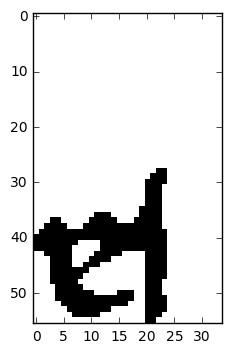

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 84.3289017677%
---
Elapsed time: 0.10114526748657227
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005008220672607422
Pipeline 3
Good cut with a confidence of 84.3289017677% by letter 's_mediana'
Good cut corresponding to letter 'b' with a confidence of 42.4995094538%
Good cut corresponding to letter 'e' with a confidence of 18.7828451395%
Good cut corresponding to letter 'f' with a confidence of 18.5748711228%
---
Elapsed time: 0.08962869644165039
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0055086612701416016


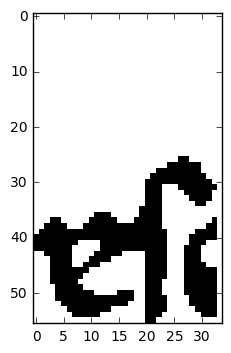

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8797237873%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 59.4188451767%
---
Elapsed time: 0.09413623809814453
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0055081844329833984
Pipeline 3
Good cut with a confidence of 99.8797237873% by letter 's_mediana'
Good cut with a confidence of 59.4188451767% by letter 'f'
Good cut corresponding to letter 'f' with a confidence of 63.0641758442%
Good cut corresponding to letter 'd_alta' with a confidence of 36.8764609098%
Good cut corresponding to letter 'g' with a confidence of 0.0553627905902%
---
Elapsed time: 0.09213781356811523
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0050067901611328125


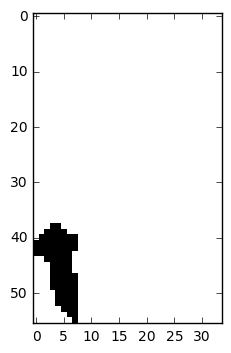

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 88.3452057838%
---
Elapsed time: 0.09463620185852051
Pipeline 2
Bad cut with a confidence of 96.4688420296%
---
Elapsed time: 0.00600886344909668
Pipeline 3
Good cut with a confidence of 88.3452057838% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.991953373%
Good cut corresponding to letter 't' with a confidence of 0.00688270811224%
Good cut corresponding to letter 'a' with a confidence of 0.000563303592571%
---
Elapsed time: 0.0911414623260498
Pipeline 4
Bad cut with a confidence of 96.4688420296%
---
Elapsed time: 0.0055084228515625


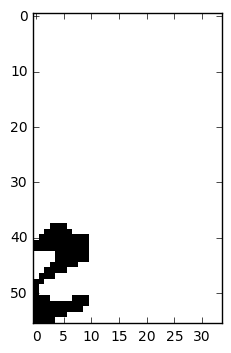

Pipeline 1
Bad cut
---
Elapsed time: 0.09363722801208496
Pipeline 2
Bad cut with a confidence of 89.5213901997%
---
Elapsed time: 0.005007266998291016
Pipeline 3
Bad cut
---
Elapsed time: 0.08261871337890625
Pipeline 4
Bad cut with a confidence of 89.5213901997%
---
Elapsed time: 0.005508899688720703


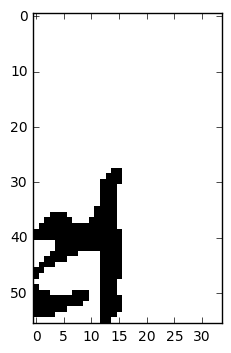

Pipeline 1
Bad cut
---
Elapsed time: 0.09663891792297363
Pipeline 2
Bad cut with a confidence of 69.5825517178%
---
Elapsed time: 0.005007028579711914
Pipeline 3
Bad cut
---
Elapsed time: 0.08562850952148438
Pipeline 4
Bad cut with a confidence of 69.5825517178%
---
Elapsed time: 0.005506992340087891


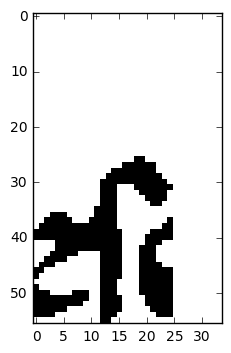

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.6388554573%
Cut 1 has been classified as good corresponding to char 'g' with a confidence of 51.46291852%
---
Elapsed time: 0.09163165092468262
Pipeline 2
Bad cut with a confidence of 99.9999880791%
---
Elapsed time: 0.005007266998291016
Pipeline 3
Good cut with a confidence of 99.6388554573% by letter 's_mediana'
Good cut with a confidence of 51.46291852% by letter 'g'
Good cut corresponding to letter 'g' with a confidence of 57.9464495182%
Good cut corresponding to letter 'f' with a confidence of 37.329274416%
Good cut corresponding to letter 'd_alta' with a confidence of 4.61534895003%
---
Elapsed time: 0.08813333511352539
Pipeline 4
Bad cut with a confidence of 99.9999880791%
---
Elapsed time: 0.0050084590911865234


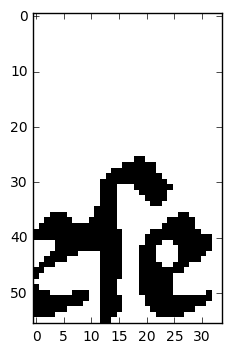

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.7483253479%
---
Elapsed time: 0.09163260459899902
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0050067901611328125
Pipeline 3
Good cut with a confidence of 99.7483253479% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 68.8668429852%
Good cut corresponding to letter 'g' with a confidence of 17.8624197841%
Good cut corresponding to letter 'd_alta' with a confidence of 12.5402271748%
---
Elapsed time: 0.08912968635559082
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005507946014404297


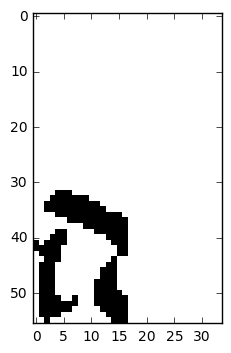

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 75.1659393311%
---
Elapsed time: 0.09914207458496094
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 70.3621923923%
Good cut corresponding to letter 's_alta' with a confidence of 14.3719166517%
Good cut corresponding to letter 'd_mediana' with a confidence of 5.15728406608%
---
Elapsed time: 0.010014533996582031
Pipeline 3
Good cut with a confidence of 75.1659393311% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 70.3621923923%
Good cut corresponding to letter 's_alta' with a confidence of 14.3719166517%
Good cut corresponding to letter 'd_mediana' with a confidence of 5.15728406608%
---
Elapsed time: 0.09063100814819336
Pipeline 4
Good cut with a confidence of 75.1659393311% by letter 's_mediana'
---
Elapsed time: 0.1006462574005127


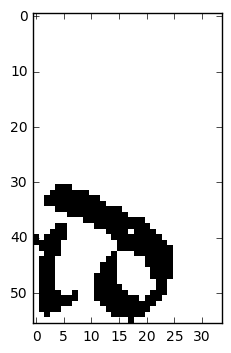

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 87.2718334198%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 70.977896452%
---
Elapsed time: 0.11216115951538086
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 99.9894976616%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.00914635093068%
Good cut corresponding to letter 's_mediana' with a confidence of 0.00134370275191%
---
Elapsed time: 0.011516571044921875
Pipeline 3
Good cut with a confidence of 87.2718334198% by letter 's_mediana'
Good cut with a confidence of 70.977896452% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9894976616%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.00914635093068%
Good cut corresponding to letter 's_mediana' with a confidence of 0.00134370275191%
---
Elapsed time: 0.0896296501159668
Pipeline 4
Good cut with a 

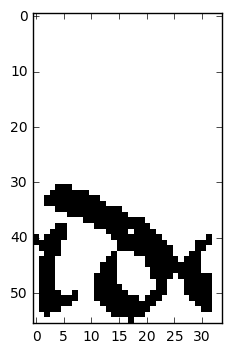

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 89.9477660656%
---
Elapsed time: 0.10915708541870117
Pipeline 2
Bad cut with a confidence of 99.9001979828%
---
Elapsed time: 0.004506826400756836
Pipeline 3
Good cut with a confidence of 89.9477660656% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.8808085918%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.118424114771%
Good cut corresponding to letter 's_mediana' with a confidence of 0.000737985465094%
---
Elapsed time: 0.08762621879577637
Pipeline 4
Bad cut with a confidence of 99.9001979828%
---
Elapsed time: 0.0050067901611328125


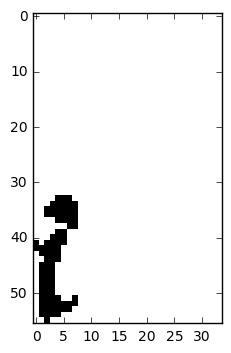

Pipeline 1
Bad cut
---
Elapsed time: 0.09363532066345215
Pipeline 2
Bad cut with a confidence of 99.9203026295%
---
Elapsed time: 0.005008220672607422
Pipeline 3
Bad cut
---
Elapsed time: 0.08311939239501953
Pipeline 4
Bad cut with a confidence of 99.9203026295%
---
Elapsed time: 0.005007028579711914


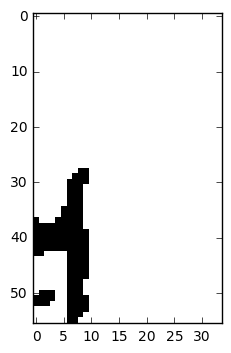

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 54.2813420296%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 68.107509613%
---
Elapsed time: 0.09263396263122559
Pipeline 2
Bad cut with a confidence of 99.9829411507%
---
Elapsed time: 0.005507230758666992
Pipeline 3
Good cut with a confidence of 54.2813420296% by letter 's_mediana'
Good cut with a confidence of 68.107509613% by letter 's_alta'
Good cut corresponding to letter 's_alta' with a confidence of 84.7082912922%
Good cut corresponding to letter 'f' with a confidence of 8.06765109301%
Good cut corresponding to letter 'l' with a confidence of 7.18784853816%
---
Elapsed time: 0.08862781524658203
Pipeline 4
Bad cut with a confidence of 99.9829411507%
---
Elapsed time: 0.006009340286254883


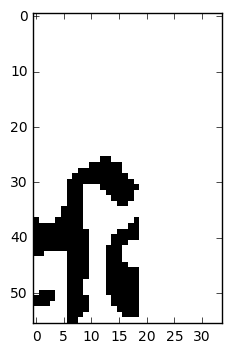

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.4972586632%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 62.0137095451%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 62.7170562744%
Cut 1 has been classified as good corresponding to char 'g' with a confidence of 52.3518025875%
---
Elapsed time: 0.08912897109985352
Pipeline 2
Good cut corresponding to letter 's_alta' with a confidence of 53.8723528385%
Good cut corresponding to letter 'f' with a confidence of 45.183545351%
Good cut corresponding to letter 'g' with a confidence of 0.563065428287%
---
Elapsed time: 0.010018587112426758
Pipeline 3
Good cut with a confidence of 99.4972586632% by letter 's_mediana'
Good cut with a confidence of 62.0137095451% by letter 's_alta'
Good cut with a confidence of 62.7170562744% by letter 'f'
Good cut with a confidence of 52.3518025875% by letter 'g'
Good cut correspondi

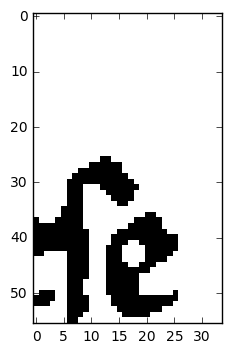

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8618721962%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 57.0827186108%
---
Elapsed time: 0.10915732383728027
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005507946014404297
Pipeline 3
Good cut with a confidence of 99.8618721962% by letter 's_mediana'
Good cut with a confidence of 57.0827186108% by letter 'f'
Good cut corresponding to letter 'f' with a confidence of 99.9315738678%
Good cut corresponding to letter 'b' with a confidence of 0.0658923643641%
Good cut corresponding to letter 'g' with a confidence of 0.00133317107611%
---
Elapsed time: 0.09063076972961426
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0055081844329833984


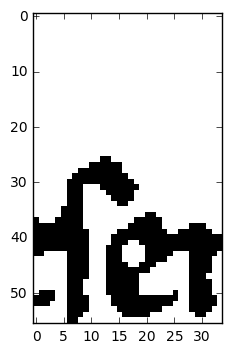

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.7909367085%
---
Elapsed time: 0.09864258766174316
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.00751042366027832
Pipeline 3
Good cut with a confidence of 99.7909367085% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 97.5580573082%
Good cut corresponding to letter 'g' with a confidence of 1.46607030183%
Good cut corresponding to letter 'd_alta' with a confidence of 0.97007965669%
---
Elapsed time: 0.09763884544372559
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.006009817123413086


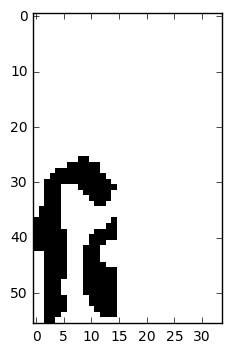

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 98.7112522125%
Cut 1 has been classified as good corresponding to char 's_alta' with a confidence of 76.9208729267%
Cut 1 has been classified as good corresponding to char 'f' with a confidence of 56.3596844673%
---
Elapsed time: 0.10064554214477539
Pipeline 2
Good cut corresponding to letter 's_alta' with a confidence of 70.7711040974%
Good cut corresponding to letter 'f' with a confidence of 29.2211025953%
Good cut corresponding to letter 'b' with a confidence of 0.00734792920412%
---
Elapsed time: 0.014020919799804688
Pipeline 3
Good cut with a confidence of 98.7112522125% by letter 's_mediana'
Good cut with a confidence of 76.9208729267% by letter 's_alta'
Good cut with a confidence of 56.3596844673% by letter 'f'
Good cut corresponding to letter 's_alta' with a confidence of 70.7711040974%
Good cut corresponding to letter 'f' with a confidence of 29.2211025953%
Good cut correspondin

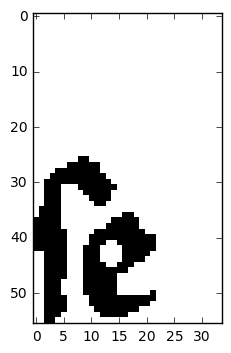

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.8586058617%
---
Elapsed time: 0.12868642807006836
Pipeline 2
Bad cut with a confidence of 99.3888497353%
---
Elapsed time: 0.008011102676391602
Pipeline 3
Good cut with a confidence of 99.8586058617% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 99.9359965324%
Good cut corresponding to letter 'd_alta' with a confidence of 0.0426165439421%
Good cut corresponding to letter 'b' with a confidence of 0.0179434195161%
---
Elapsed time: 0.1251811981201172
Pipeline 4
Bad cut with a confidence of 99.3888497353%
---
Elapsed time: 0.007009744644165039


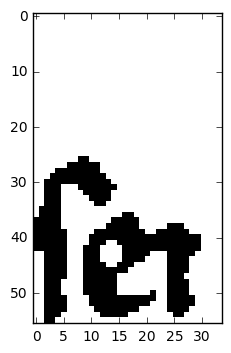

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.7886955738%
---
Elapsed time: 0.12818455696105957
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0065097808837890625
Pipeline 3
Good cut with a confidence of 99.7886955738% by letter 's_mediana'
Good cut corresponding to letter 'f' with a confidence of 90.1226699352%
Good cut corresponding to letter 'd_alta' with a confidence of 9.55825522542%
Good cut corresponding to letter 'g' with a confidence of 0.269282585941%
---
Elapsed time: 0.1221771240234375
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.006508827209472656


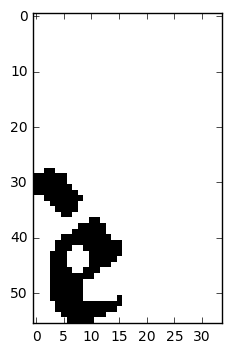

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.9439418316%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 95.2869415283%
---
Elapsed time: 0.1301877498626709
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 99.7500777245%
Good cut corresponding to letter 's_bassa' with a confidence of 0.238754367456%
Good cut corresponding to letter 'e' with a confidence of 0.0108915075543%
---
Elapsed time: 0.01301884651184082
Pipeline 3
Good cut with a confidence of 99.9439418316% by letter 's_mediana'
Good cut with a confidence of 95.2869415283% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.7500777245%
Good cut corresponding to letter 's_bassa' with a confidence of 0.238754367456%
Good cut corresponding to letter 'e' with a confidence of 0.0108915075543%
---
Elapsed time: 0.1246802806854248
Pipeline 4
Good cut with a confidence of 99.943941831

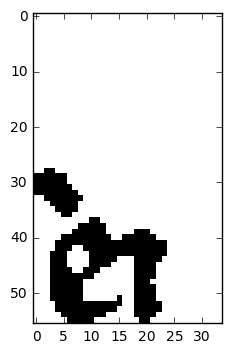

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 50.8759498596%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.9576091766%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 94.0831184387%
---
Elapsed time: 0.1246800422668457
Pipeline 2
Bad cut with a confidence of 90.8892810345%
---
Elapsed time: 0.007010459899902344
Pipeline 3
Good cut with a confidence of 50.8759498596% by letter 'a'
Good cut with a confidence of 99.9576091766% by letter 's_mediana'
Good cut with a confidence of 94.0831184387% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9985873699%
Good cut corresponding to letter 'b' with a confidence of 0.00126501208797%
Good cut corresponding to letter 'e' with a confidence of 6.86679754835e-05%
---
Elapsed time: 0.10665464401245117
Pipeline 4
Bad cut with a confidence of 90.8892810345%
---
Elapsed time: 0.006008148193

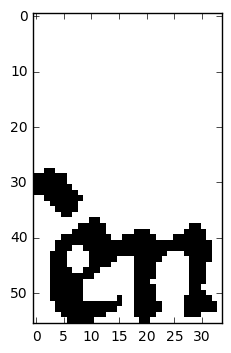

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 99.9380111694%
---
Elapsed time: 0.0921330451965332
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.006008625030517578
Pipeline 3
Good cut with a confidence of 99.9380111694% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9736428261%
Good cut corresponding to letter 'b' with a confidence of 0.0261467183009%
Good cut corresponding to letter 'f' with a confidence of 0.000165842118349%
---
Elapsed time: 0.09964394569396973
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005007505416870117


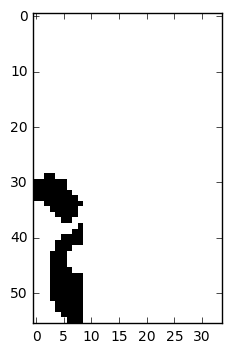

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 96.914690733%
---
Elapsed time: 0.10214805603027344
Pipeline 2
Bad cut with a confidence of 99.9999701977%
---
Elapsed time: 0.0060079097747802734
Pipeline 3
Good cut with a confidence of 96.914690733% by letter 's_mediana'
Good cut corresponding to letter 'l' with a confidence of 99.9530911446%
Good cut corresponding to letter 's_bassa' with a confidence of 0.0396151648602%
Good cut corresponding to letter 'q' with a confidence of 0.00464429285785%
---
Elapsed time: 0.09613895416259766
Pipeline 4
Bad cut with a confidence of 99.9999701977%
---
Elapsed time: 0.0055086612701416016


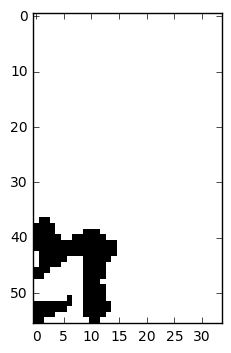

Pipeline 1
Bad cut
---
Elapsed time: 0.09814119338989258
Pipeline 2
Bad cut with a confidence of 53.1730949879%
---
Elapsed time: 0.0055081844329833984
Pipeline 3
Bad cut
---
Elapsed time: 0.08812713623046875
Pipeline 4
Bad cut with a confidence of 53.1730949879%
---
Elapsed time: 0.005007505416870117


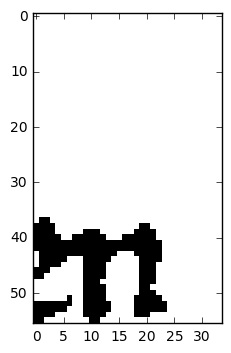

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 97.8550255299%
---
Elapsed time: 0.09714031219482422
Pipeline 2
Good cut corresponding to letter 'm' with a confidence of 100.0%
Good cut corresponding to letter 'n' with a confidence of 7.6677828531e-07%
Good cut corresponding to letter 'd_mediana' with a confidence of 9.41102543117e-09%
---
Elapsed time: 0.010515213012695312
Pipeline 3
Good cut with a confidence of 97.8550255299% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 100.0%
Good cut corresponding to letter 'n' with a confidence of 7.6677828531e-07%
Good cut corresponding to letter 'd_mediana' with a confidence of 9.41102543117e-09%
---
Elapsed time: 0.09163260459899902
Pipeline 4
Good cut with a confidence of 97.8550255299% by letter 'm'
---
Elapsed time: 0.09663939476013184


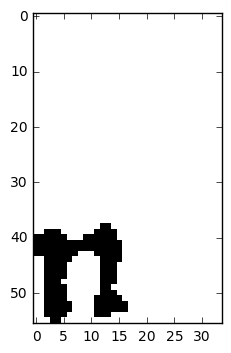

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 97.8331387043%
---
Elapsed time: 0.11216115951538086
Pipeline 2
Good cut corresponding to letter 'n' with a confidence of 99.9767482281%
Good cut corresponding to letter 'o' with a confidence of 0.0226137490245%
Good cut corresponding to letter 'u' with a confidence of 0.000289882018478%
---
Elapsed time: 0.011016368865966797
Pipeline 3
Good cut with a confidence of 97.8331387043% by letter 'n'
Good cut corresponding to letter 'n' with a confidence of 99.9767482281%
Good cut corresponding to letter 'o' with a confidence of 0.0226137490245%
Good cut corresponding to letter 'u' with a confidence of 0.000289882018478%
---
Elapsed time: 0.09461212158203125
Pipeline 4
Good cut with a confidence of 97.8331387043% by letter 'n'
---
Elapsed time: 0.10364389419555664


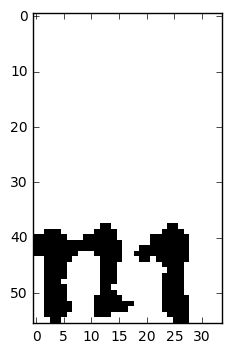

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 81.0501396656%
---
Elapsed time: 0.09814190864562988
Pipeline 2
Bad cut with a confidence of 87.655800581%
---
Elapsed time: 0.006008625030517578
Pipeline 3
Good cut with a confidence of 81.0501396656% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 100.0%
Good cut corresponding to letter 'e' with a confidence of 2.28069492181e-06%
Good cut corresponding to letter 'n' with a confidence of 1.21516452456e-07%
---
Elapsed time: 0.09914326667785645
Pipeline 4
Bad cut with a confidence of 87.655800581%
---
Elapsed time: 0.005007028579711914


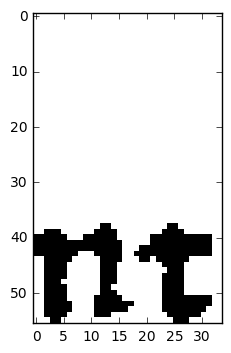

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 79.2249560356%
---
Elapsed time: 0.10214734077453613
Pipeline 2
Bad cut with a confidence of 88.0549252033%
---
Elapsed time: 0.005507469177246094
Pipeline 3
Good cut with a confidence of 79.2249560356% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 99.9999880791%
Good cut corresponding to letter 'd_mediana' with a confidence of 8.44397476385e-06%
Good cut corresponding to letter 'e' with a confidence of 3.8205505426e-07%
---
Elapsed time: 0.09664058685302734
Pipeline 4
Bad cut with a confidence of 88.0549252033%
---
Elapsed time: 0.0060083866119384766


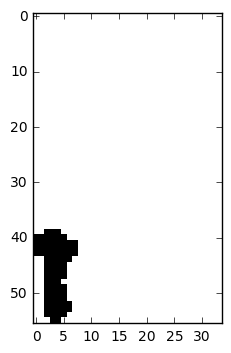

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 84.9537670612%
---
Elapsed time: 0.10715556144714355
Pipeline 2
Bad cut with a confidence of 99.8439908028%
---
Elapsed time: 0.0070095062255859375
Pipeline 3
Good cut with a confidence of 84.9537670612% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9955356121%
Good cut corresponding to letter 't' with a confidence of 0.00284969901259%
Good cut corresponding to letter 'a' with a confidence of 0.00126110126075%
---
Elapsed time: 0.09864473342895508
Pipeline 4
Bad cut with a confidence of 99.8439908028%
---
Elapsed time: 0.00851297378540039


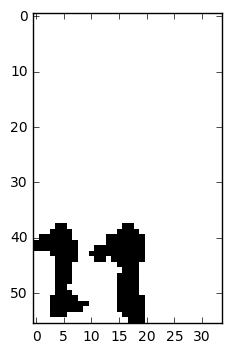

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 52.1431088448%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 71.4888751507%
---
Elapsed time: 0.1001436710357666
Pipeline 2
Bad cut with a confidence of 95.6904292107%
---
Elapsed time: 0.006007671356201172
Pipeline 3
Good cut with a confidence of 52.1431088448% by letter 'i'
Good cut with a confidence of 71.4888751507% by letter 'u'
Good cut corresponding to letter 'u' with a confidence of 99.91492033%
Good cut corresponding to letter 'n' with a confidence of 0.0835630460642%
Good cut corresponding to letter 'a' with a confidence of 0.000889125840331%
---
Elapsed time: 0.09416007995605469
Pipeline 4
Bad cut with a confidence of 95.6904292107%
---
Elapsed time: 0.005007028579711914


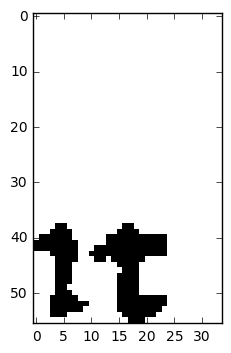

Pipeline 1
Bad cut
---
Elapsed time: 0.09113168716430664
Pipeline 2
Bad cut with a confidence of 99.3504524231%
---
Elapsed time: 0.005507707595825195
Pipeline 3
Bad cut
---
Elapsed time: 0.08111739158630371
Pipeline 4
Bad cut with a confidence of 99.3504524231%
---
Elapsed time: 0.005507230758666992


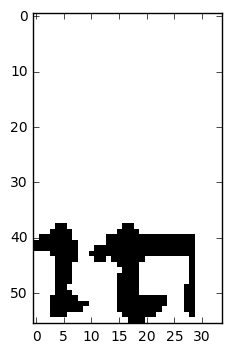

Pipeline 1
Bad cut
---
Elapsed time: 0.09613919258117676
Pipeline 2
Bad cut with a confidence of 98.6654937267%
---
Elapsed time: 0.005007028579711914
Pipeline 3
Bad cut
---
Elapsed time: 0.08211803436279297
Pipeline 4
Bad cut with a confidence of 98.6654937267%
---
Elapsed time: 0.005007266998291016


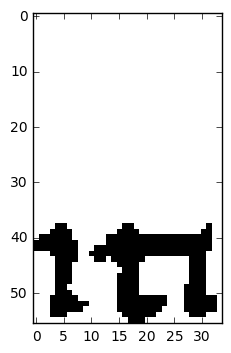

Pipeline 1
Bad cut
---
Elapsed time: 0.09263443946838379
Pipeline 2
Bad cut with a confidence of 99.7042477131%
---
Elapsed time: 0.005007505416870117
Pipeline 3
Bad cut
---
Elapsed time: 0.07862305641174316
Pipeline 4
Bad cut with a confidence of 99.7042477131%
---
Elapsed time: 0.005507230758666992


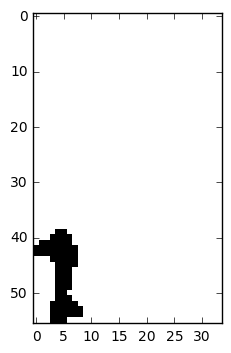

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 92.947101593%
---
Elapsed time: 0.09163188934326172
Pipeline 2
Bad cut with a confidence of 78.2877385616%
---
Elapsed time: 0.0055086612701416016
Pipeline 3
Good cut with a confidence of 92.947101593% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9989032745%
Good cut corresponding to letter 't' with a confidence of 0.000486960607304%
Good cut corresponding to letter 'l' with a confidence of 0.000442978762294%
---
Elapsed time: 0.08962869644165039
Pipeline 4
Bad cut with a confidence of 78.2877385616%
---
Elapsed time: 0.006009101867675781


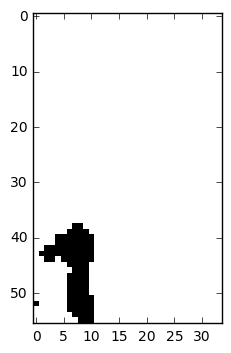

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 56.2138438225%
---
Elapsed time: 0.09163212776184082
Pipeline 2
Bad cut with a confidence of 82.9393744469%
---
Elapsed time: 0.005507707595825195
Pipeline 3
Good cut with a confidence of 56.2138438225% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.8688578606%
Good cut corresponding to letter 't' with a confidence of 0.121956609655%
Good cut corresponding to letter 'r' with a confidence of 0.00672415044392%
---
Elapsed time: 0.14871573448181152
Pipeline 4
Bad cut with a confidence of 82.9393744469%
---
Elapsed time: 0.006509065628051758


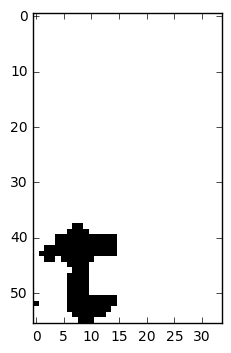

Pipeline 1
Cut 1 has been classified as good corresponding to char 'r' with a confidence of 74.9092519283%
Cut 1 has been classified as good corresponding to char 't' with a confidence of 95.8890080452%
---
Elapsed time: 0.1577284336090088
Pipeline 2
Good cut corresponding to letter 't' with a confidence of 99.8385071754%
Good cut corresponding to letter 'i' with a confidence of 0.100469822064%
Good cut corresponding to letter 'r' with a confidence of 0.0610154122114%
---
Elapsed time: 0.014020204544067383
Pipeline 3
Good cut with a confidence of 74.9092519283% by letter 'r'
Good cut with a confidence of 95.8890080452% by letter 't'
Good cut corresponding to letter 't' with a confidence of 99.8385071754%
Good cut corresponding to letter 'i' with a confidence of 0.100469822064%
Good cut corresponding to letter 'r' with a confidence of 0.0610154122114%
---
Elapsed time: 0.1437077522277832
Pipeline 4
Good cut with a confidence of 74.9092519283% by letter 'r'
Good cut with a confidence of 

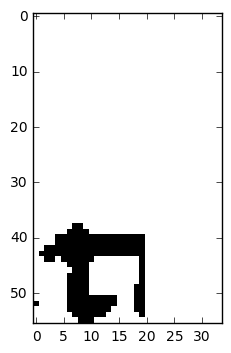

Pipeline 1
Cut 1 has been classified as good corresponding to char 't' with a confidence of 63.5220348835%
---
Elapsed time: 0.09563684463500977
Pipeline 2
Bad cut with a confidence of 57.2398781776%
---
Elapsed time: 0.00500798225402832
Pipeline 3
Good cut with a confidence of 63.5220348835% by letter 't'
Good cut corresponding to letter 't' with a confidence of 99.905025959%
Good cut corresponding to letter 'n' with a confidence of 0.0914015516173%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.00278668248939%
---
Elapsed time: 0.08762621879577637
Pipeline 4
Bad cut with a confidence of 57.2398781776%
---
Elapsed time: 0.005507707595825195


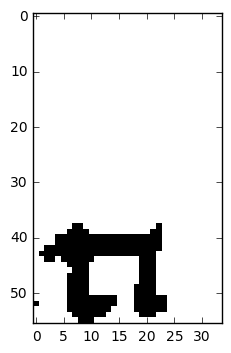

Pipeline 1
Bad cut
---
Elapsed time: 0.09363555908203125
Pipeline 2
Bad cut with a confidence of 99.9999880791%
---
Elapsed time: 0.0055081844329833984
Pipeline 3
Bad cut
---
Elapsed time: 0.08512282371520996
Pipeline 4
Bad cut with a confidence of 99.9999880791%
---
Elapsed time: 0.005008220672607422


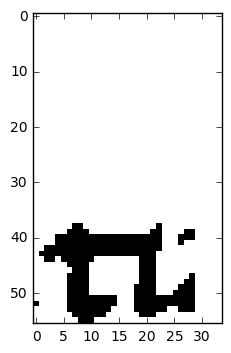

Pipeline 1
Bad cut
---
Elapsed time: 0.09313392639160156
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.0055084228515625
Pipeline 3
Bad cut
---
Elapsed time: 0.08410859107971191
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005508899688720703


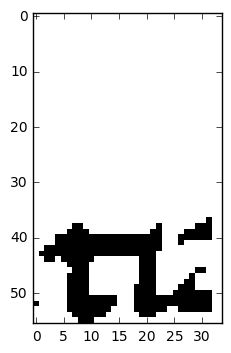

Pipeline 1
Bad cut
---
Elapsed time: 0.09563851356506348
Pipeline 2
Bad cut with a confidence of 99.9977707863%
---
Elapsed time: 0.005006551742553711
Pipeline 3
Bad cut
---
Elapsed time: 0.08534049987792969
Pipeline 4
Bad cut with a confidence of 99.9977707863%
---
Elapsed time: 0.0050067901611328125


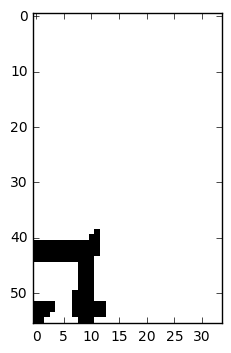

Pipeline 1
Bad cut
---
Elapsed time: 0.09463620185852051
Pipeline 2
Bad cut with a confidence of 99.9024510384%
---
Elapsed time: 0.005007743835449219
Pipeline 3
Bad cut
---
Elapsed time: 0.08261966705322266
Pipeline 4
Bad cut with a confidence of 99.9024510384%
---
Elapsed time: 0.005507230758666992


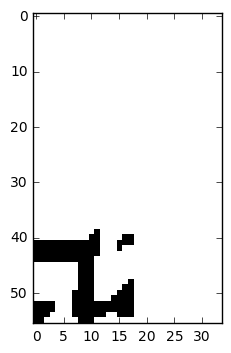

Pipeline 1
Bad cut
---
Elapsed time: 0.09714007377624512
Pipeline 2
Good cut corresponding to letter 't' with a confidence of 99.0468621254%
Good cut corresponding to letter 'r' with a confidence of 0.932295806706%
Good cut corresponding to letter 'c' with a confidence of 0.0080130812421%
---
Elapsed time: 0.011015892028808594
Pipeline 3
Bad cut
---
Elapsed time: 0.0866248607635498
Pipeline 4
---
Elapsed time: 0.10214781761169434


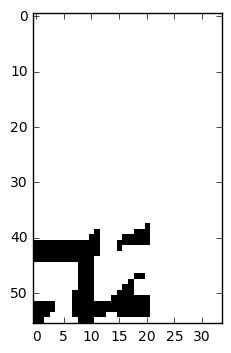

Pipeline 1
Bad cut
---
Elapsed time: 0.11065936088562012
Pipeline 2
Bad cut with a confidence of 75.7824778557%
---
Elapsed time: 0.0075109004974365234
Pipeline 3
Bad cut
---
Elapsed time: 0.08912849426269531
Pipeline 4
Bad cut with a confidence of 75.7824778557%
---
Elapsed time: 0.005507946014404297


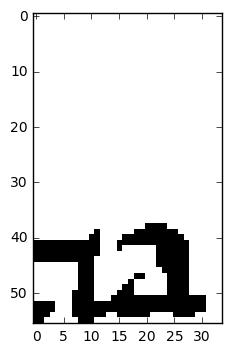

Pipeline 1
Bad cut
---
Elapsed time: 0.09463715553283691
Pipeline 2
Bad cut with a confidence of 99.8976707458%
---
Elapsed time: 0.005007266998291016
Pipeline 3
Bad cut
---
Elapsed time: 0.08462166786193848
Pipeline 4
Bad cut with a confidence of 99.8976707458%
---
Elapsed time: 0.0055084228515625


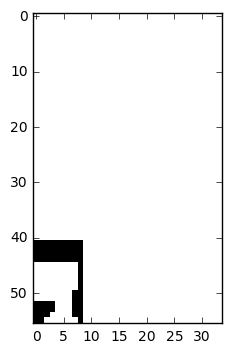

Pipeline 1
Bad cut
---
Elapsed time: 0.09463715553283691
Pipeline 2
Bad cut with a confidence of 99.9639809132%
---
Elapsed time: 0.005006313323974609
Pipeline 3
Bad cut
---
Elapsed time: 0.08863520622253418
Pipeline 4
Bad cut with a confidence of 99.9639809132%
---
Elapsed time: 0.0060083866119384766


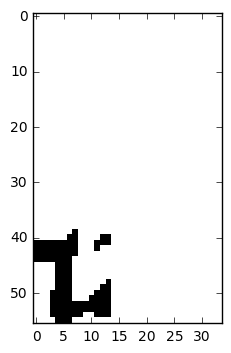

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 72.0271766186%
Cut 1 has been classified as good corresponding to char 'r' with a confidence of 92.3202216625%
---
Elapsed time: 0.0976400375366211
Pipeline 2
Good cut corresponding to letter 'i' with a confidence of 71.2310433388%
Good cut corresponding to letter 'r' with a confidence of 26.1988133192%
Good cut corresponding to letter 't' with a confidence of 2.56873723119%
---
Elapsed time: 0.010515928268432617
Pipeline 3
Good cut with a confidence of 72.0271766186% by letter 'i'
Good cut with a confidence of 92.3202216625% by letter 'r'
Good cut corresponding to letter 'i' with a confidence of 71.2310433388%
Good cut corresponding to letter 'r' with a confidence of 26.1988133192%
Good cut corresponding to letter 't' with a confidence of 2.56873723119%
---
Elapsed time: 0.09013009071350098
Pipeline 4
Good cut with a confidence of 72.0271766186% by letter 'i'
Good cut with a confidence of 92.32

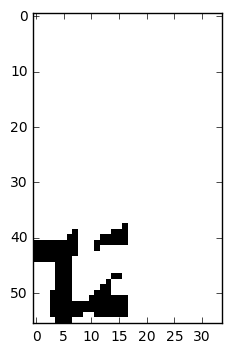

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 80.4447054863%
Cut 1 has been classified as good corresponding to char 'r' with a confidence of 73.2954144478%
Cut 1 has been classified as good corresponding to char 'u' with a confidence of 59.8724842072%
---
Elapsed time: 0.10965991020202637
Pipeline 2
Good cut corresponding to letter 'i' with a confidence of 51.0966420174%
Good cut corresponding to letter 'r' with a confidence of 43.3270931244%
Good cut corresponding to letter 't' with a confidence of 5.4862678051%
---
Elapsed time: 0.011516571044921875
Pipeline 3
Good cut with a confidence of 80.4447054863% by letter 'i'
Good cut with a confidence of 73.2954144478% by letter 'r'
Good cut with a confidence of 59.8724842072% by letter 'u'
Good cut corresponding to letter 'i' with a confidence of 51.0966420174%
Good cut corresponding to letter 'r' with a confidence of 43.3270931244%
Good cut corresponding to letter 't' with a confidence of 5.4

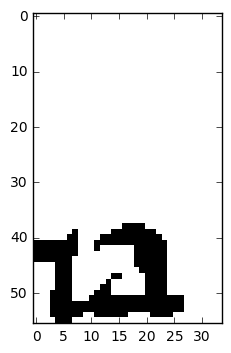

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 62.5580787659%
---
Elapsed time: 0.11166119575500488
Pipeline 2
Bad cut with a confidence of 96.7688858509%
---
Elapsed time: 0.005007266998291016
Pipeline 3
Good cut with a confidence of 62.5580787659% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 98.6300468445%
Good cut corresponding to letter 'e' with a confidence of 1.02007342502%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.193641369697%
---
Elapsed time: 0.10114622116088867
Pipeline 4
Bad cut with a confidence of 96.7688858509%
---
Elapsed time: 0.0075113773345947266


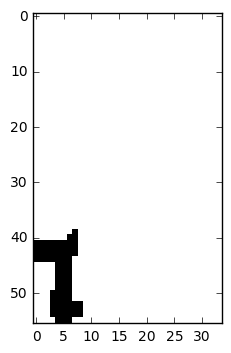

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 82.7174961567%
---
Elapsed time: 0.10965824127197266
Pipeline 2
Bad cut with a confidence of 80.649793148%
---
Elapsed time: 0.0055084228515625
Pipeline 3
Good cut with a confidence of 82.7174961567% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9840080738%
Good cut corresponding to letter 't' with a confidence of 0.0142183474964%
Good cut corresponding to letter 'l' with a confidence of 0.000883103894012%
---
Elapsed time: 0.08912825584411621
Pipeline 4
Bad cut with a confidence of 80.649793148%
---
Elapsed time: 0.005507707595825195


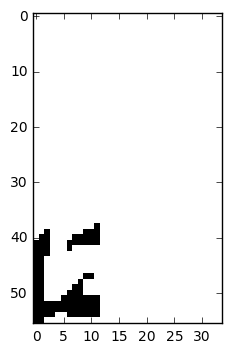

Pipeline 1
Bad cut
---
Elapsed time: 0.10765528678894043
Pipeline 2
Bad cut with a confidence of 71.548306942%
---
Elapsed time: 0.005507707595825195
Pipeline 3
Bad cut
---
Elapsed time: 0.08912897109985352
Pipeline 4
Bad cut with a confidence of 71.548306942%
---
Elapsed time: 0.005507469177246094


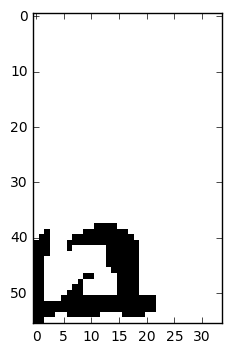

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 99.6958136559%
---
Elapsed time: 0.11166167259216309
Pipeline 2
Good cut corresponding to letter 'a' with a confidence of 99.9992251396%
Good cut corresponding to letter 'e' with a confidence of 0.000642388113192%
Good cut corresponding to letter 'r' with a confidence of 8.64121659561e-05%
---
Elapsed time: 0.015522241592407227
Pipeline 3
Good cut with a confidence of 99.6958136559% by letter 'a'
Good cut corresponding to letter 'a' with a confidence of 99.9992251396%
Good cut corresponding to letter 'e' with a confidence of 0.000642388113192%
Good cut corresponding to letter 'r' with a confidence of 8.64121659561e-05%
---
Elapsed time: 0.10031414031982422
Pipeline 4
Good cut with a confidence of 99.6958136559% by letter 'a'
---
Elapsed time: 0.09914302825927734


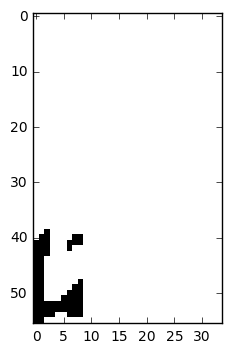

Pipeline 1
Bad cut
---
Elapsed time: 0.10415053367614746
Pipeline 2
Bad cut with a confidence of 93.0565953255%
---
Elapsed time: 0.006509065628051758
Pipeline 3
Bad cut
---
Elapsed time: 0.09263730049133301
Pipeline 4
Bad cut with a confidence of 93.0565953255%
---
Elapsed time: 0.005507707595825195


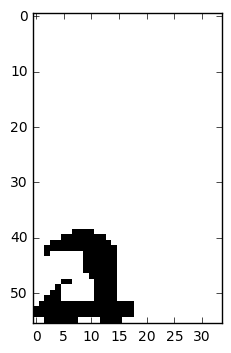

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 99.7737407684%
Cut 1 has been classified as good corresponding to char 'o' with a confidence of 59.1299474239%
---
Elapsed time: 0.1111602783203125
Pipeline 2
Good cut corresponding to letter 'a' with a confidence of 99.9995529652%
Good cut corresponding to letter 'i' with a confidence of 0.000400825047109%
Good cut corresponding to letter 't' with a confidence of 2.88050870267e-05%
---
Elapsed time: 0.012517690658569336
Pipeline 3
Good cut with a confidence of 99.7737407684% by letter 'a'
Good cut with a confidence of 59.1299474239% by letter 'o'
Good cut corresponding to letter 'a' with a confidence of 99.9995529652%
Good cut corresponding to letter 'i' with a confidence of 0.000400825047109%
Good cut corresponding to letter 't' with a confidence of 2.88050870267e-05%
---
Elapsed time: 0.10715508460998535
Pipeline 4
Good cut with a confidence of 99.7737407684% by letter 'a'
Good cut with a con

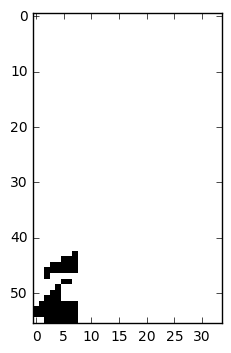

Pipeline 1
Bad cut
---
Elapsed time: 0.0951380729675293
Pipeline 2
Bad cut with a confidence of 99.2580771446%
---
Elapsed time: 0.006508827209472656
Pipeline 3
Bad cut
---
Elapsed time: 0.08963394165039062
Pipeline 4
Bad cut with a confidence of 99.2580771446%
---
Elapsed time: 0.005007505416870117


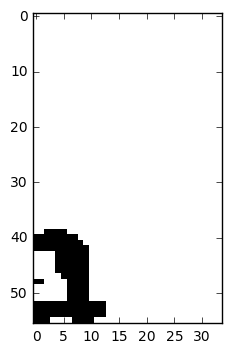

Pipeline 1
Cut 1 has been classified as good corresponding to char 'a' with a confidence of 52.355247736%
---
Elapsed time: 0.09613871574401855
Pipeline 2
Bad cut with a confidence of 99.5013415813%
---
Elapsed time: 0.0055081844329833984
Pipeline 3
Good cut with a confidence of 52.355247736% by letter 'a'
Good cut corresponding to letter 'i' with a confidence of 88.3647143841%
Good cut corresponding to letter 'a' with a confidence of 11.6039857268%
Good cut corresponding to letter 'r' with a confidence of 0.0242293070187%
---
Elapsed time: 0.0896296501159668
Pipeline 4
Bad cut with a confidence of 99.5013415813%
---
Elapsed time: 0.005006551742553711


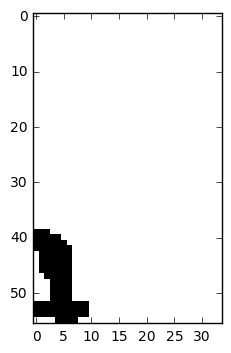

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 57.2877407074%
---
Elapsed time: 0.08815503120422363
Pipeline 2
Bad cut with a confidence of 97.6182103157%
---
Elapsed time: 0.005506992340087891
Pipeline 3
Good cut with a confidence of 57.2877407074% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.4571328163%
Good cut corresponding to letter 'a' with a confidence of 0.538721168414%
Good cut corresponding to letter 'r' with a confidence of 0.00138809027703%
---
Elapsed time: 0.08762645721435547
Pipeline 4
Bad cut with a confidence of 97.6182103157%
---
Elapsed time: 0.00500941276550293


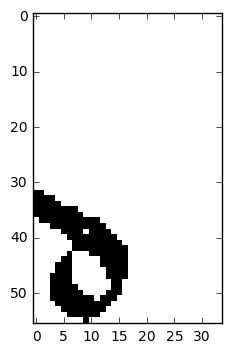

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 98.755300045%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 98.3262836933%
---
Elapsed time: 0.0921335220336914
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 99.7219741344%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.277932430618%
Good cut corresponding to letter 'a' with a confidence of 3.35905042448e-05%
---
Elapsed time: 0.011014938354492188
Pipeline 3
Good cut with a confidence of 98.755300045% by letter 's_mediana'
Good cut with a confidence of 98.3262836933% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.7219741344%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.277932430618%
Good cut corresponding to letter 'a' with a confidence of 3.35905042448e-05%
---
Elapsed time: 0.08956313133239746
Pipeline 4
Good cut with a confidence of 98.7

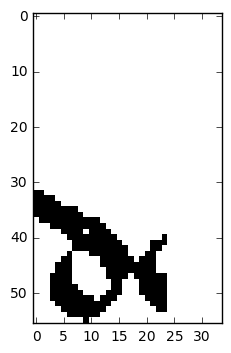

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 98.730546236%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 94.6561813354%
---
Elapsed time: 0.09864187240600586
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 99.9432444572%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.0563493173104%
Good cut corresponding to letter 'a' with a confidence of 0.0002451007731%
---
Elapsed time: 0.011015653610229492
Pipeline 3
Good cut with a confidence of 98.730546236% by letter 's_mediana'
Good cut with a confidence of 94.6561813354% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 99.9432444572%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.0563493173104%
Good cut corresponding to letter 'a' with a confidence of 0.0002451007731%
---
Elapsed time: 0.0871267318725586
Pipeline 4
Good cut with a confidence of 98.730

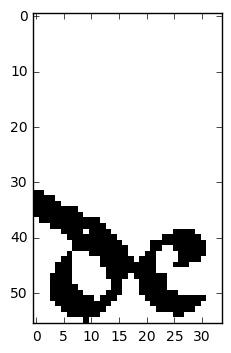

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 97.007381916%
---
Elapsed time: 0.10915803909301758
Pipeline 2
Bad cut with a confidence of 99.9999880791%
---
Elapsed time: 0.005507707595825195
Pipeline 3
Good cut with a confidence of 97.007381916% by letter 's_mediana'
Good cut corresponding to letter 'd_alta' with a confidence of 99.5186150074%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.480647711083%
Good cut corresponding to letter 'q' with a confidence of 0.000601867122896%
---
Elapsed time: 0.09012985229492188
Pipeline 4
Bad cut with a confidence of 99.9999880791%
---
Elapsed time: 0.006009817123413086


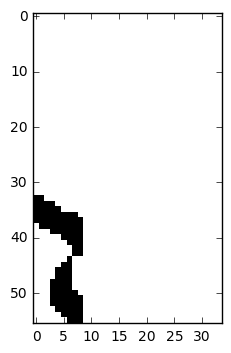

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 95.8662867546%
---
Elapsed time: 0.09413576126098633
Pipeline 2
Bad cut with a confidence of 99.9999165535%
---
Elapsed time: 0.0055086612701416016
Pipeline 3
Good cut with a confidence of 95.8662867546% by letter 's_mediana'
Good cut corresponding to letter 'c' with a confidence of 51.6690015793%
Good cut corresponding to letter 'i' with a confidence of 46.8431532383%
Good cut corresponding to letter 's_alta' with a confidence of 0.616199988872%
---
Elapsed time: 0.09713959693908691
Pipeline 4
Bad cut with a confidence of 99.9999165535%
---
Elapsed time: 0.005007743835449219


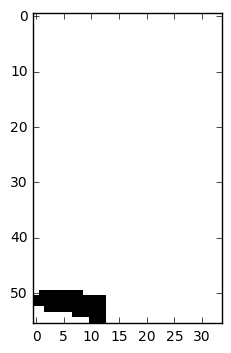

Pipeline 1
Bad cut
---
Elapsed time: 0.10815620422363281
Pipeline 2
Bad cut with a confidence of 99.1404354572%
---
Elapsed time: 0.005507707595825195
Pipeline 3
Bad cut
---
Elapsed time: 0.10014533996582031
Pipeline 4
Bad cut with a confidence of 99.1404354572%
---
Elapsed time: 0.007009983062744141


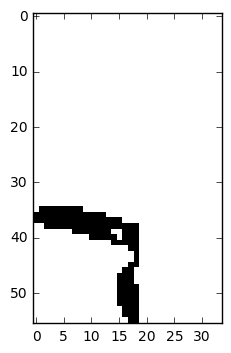

Pipeline 1
Cut 1 has been classified as good corresponding to char 'd_mediana' with a confidence of 97.6035773754%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 73.931658268%
---
Elapsed time: 0.09864306449890137
Pipeline 2
Bad cut with a confidence of 81.9494128227%
---
Elapsed time: 0.007009744644165039
Pipeline 3
Good cut with a confidence of 97.6035773754% by letter 'd_mediana'
Good cut with a confidence of 73.931658268% by letter 's_mediana'
Good cut corresponding to letter 'd_mediana' with a confidence of 85.7562839985%
Good cut corresponding to letter 't' with a confidence of 7.13943243027%
Good cut corresponding to letter 'c' with a confidence of 3.60215604305%
---
Elapsed time: 0.11266303062438965
Pipeline 4
Bad cut with a confidence of 81.9494128227%
---
Elapsed time: 0.007010221481323242


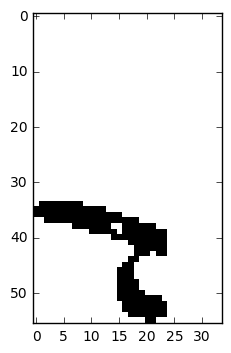

Pipeline 1
Cut 1 has been classified as good corresponding to char 'd_mediana' with a confidence of 98.3881950378%
---
Elapsed time: 0.11616778373718262
Pipeline 2
Bad cut with a confidence of 95.5655932426%
---
Elapsed time: 0.007511138916015625
Pipeline 3
Good cut with a confidence of 98.3881950378% by letter 'd_mediana'
Good cut corresponding to letter 'd_mediana' with a confidence of 71.8476593494%
Good cut corresponding to letter 'd_alta' with a confidence of 28.1397819519%
Good cut corresponding to letter 'a' with a confidence of 0.00553385943931%
---
Elapsed time: 0.09714102745056152
Pipeline 4
Bad cut with a confidence of 95.5655932426%
---
Elapsed time: 0.007009267807006836


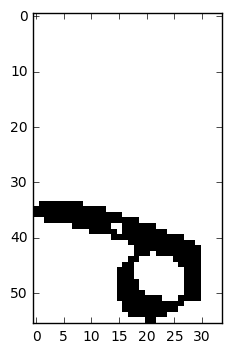

Pipeline 1
Cut 1 has been classified as good corresponding to char 'd_mediana' with a confidence of 97.5098252296%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 51.5865981579%
---
Elapsed time: 0.10364913940429688
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 65.1023328304%
Good cut corresponding to letter 'd_mediana' with a confidence of 34.8976045847%
Good cut corresponding to letter 'o' with a confidence of 2.54260925203e-05%
---
Elapsed time: 0.012017011642456055
Pipeline 3
Good cut with a confidence of 97.5098252296% by letter 'd_mediana'
Good cut with a confidence of 51.5865981579% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 65.1023328304%
Good cut corresponding to letter 'd_mediana' with a confidence of 34.8976045847%
Good cut corresponding to letter 'o' with a confidence of 2.54260925203e-05%
---
Elapsed time: 0.13219189643859863
Pipeline 4
Good cut with a confidence of 97.

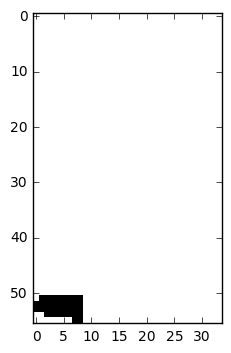

Pipeline 1
Bad cut
---
Elapsed time: 0.1221768856048584
Pipeline 2
Bad cut with a confidence of 99.1404354572%
---
Elapsed time: 0.006509065628051758
Pipeline 3
Bad cut
---
Elapsed time: 0.12968683242797852
Pipeline 4
Bad cut with a confidence of 99.1404354572%
---
Elapsed time: 0.006509542465209961


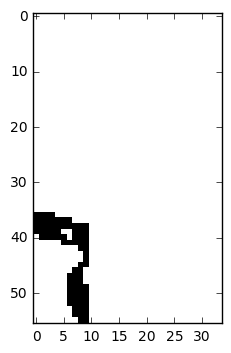

Pipeline 1
Cut 1 has been classified as good corresponding to char 'c' with a confidence of 81.8158447742%
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 92.835187912%
---
Elapsed time: 0.11967301368713379
Pipeline 2
Bad cut with a confidence of 99.9098777771%
---
Elapsed time: 0.007511615753173828
Pipeline 3
Good cut with a confidence of 81.8158447742% by letter 'c'
Good cut with a confidence of 92.835187912% by letter 's_mediana'
Good cut corresponding to letter 'c' with a confidence of 85.5508923531%
Good cut corresponding to letter 'i' with a confidence of 10.1818025112%
Good cut corresponding to letter 'r' with a confidence of 3.63307148218%
---
Elapsed time: 0.1301877498626709
Pipeline 4
Bad cut with a confidence of 99.9098777771%
---
Elapsed time: 0.008011817932128906


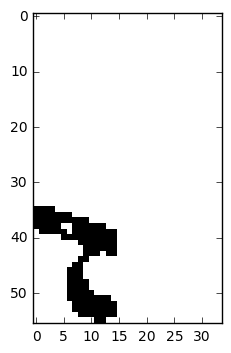

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 57.319355011%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 55.2528679371%
---
Elapsed time: 0.11917257308959961
Pipeline 2
Bad cut with a confidence of 99.8128592968%
---
Elapsed time: 0.0060083866119384766
Pipeline 3
Good cut with a confidence of 57.319355011% by letter 's_mediana'
Good cut with a confidence of 55.2528679371% by letter 'd_alta'
Good cut corresponding to letter 't' with a confidence of 32.1916550398%
Good cut corresponding to letter 'd_alta' with a confidence of 26.7213225365%
Good cut corresponding to letter 'r' with a confidence of 22.7204084396%
---
Elapsed time: 0.12568187713623047
Pipeline 4
Bad cut with a confidence of 99.8128592968%
---
Elapsed time: 0.007010221481323242


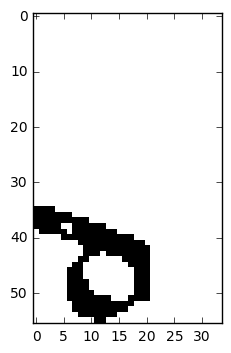

Pipeline 1
Cut 1 has been classified as good corresponding to char 'd_mediana' with a confidence of 88.8140380383%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 80.1630616188%
---
Elapsed time: 0.11266350746154785
Pipeline 2
Good cut corresponding to letter 'd_mediana' with a confidence of 80.0328075886%
Good cut corresponding to letter 'd_alta' with a confidence of 19.9644476175%
Good cut corresponding to letter 'a' with a confidence of 0.00251427554758%
---
Elapsed time: 0.014019489288330078
Pipeline 3
Good cut with a confidence of 88.8140380383% by letter 'd_mediana'
Good cut with a confidence of 80.1630616188% by letter 'd_alta'
Good cut corresponding to letter 'd_mediana' with a confidence of 80.0328075886%
Good cut corresponding to letter 'd_alta' with a confidence of 19.9644476175%
Good cut corresponding to letter 'a' with a confidence of 0.00251427554758%
---
Elapsed time: 0.1326920986175537
Pipeline 4
Good cut with a confidence of 88.814

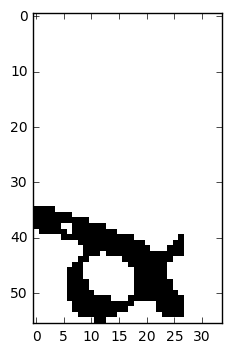

Pipeline 1
Cut 1 has been classified as good corresponding to char 'd_mediana' with a confidence of 70.2668786049%
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 58.7624430656%
---
Elapsed time: 0.11216211318969727
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 79.1527867317%
Good cut corresponding to letter 'd_mediana' with a confidence of 20.8470508456%
Good cut corresponding to letter 'e' with a confidence of 9.45381430029e-05%
---
Elapsed time: 0.01552271842956543
Pipeline 3
Good cut with a confidence of 70.2668786049% by letter 'd_mediana'
Good cut with a confidence of 58.7624430656% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 79.1527867317%
Good cut corresponding to letter 'd_mediana' with a confidence of 20.8470508456%
Good cut corresponding to letter 'e' with a confidence of 9.45381430029e-05%
---
Elapsed time: 0.09313464164733887
Pipeline 4
Good cut with a confidence of 70.2

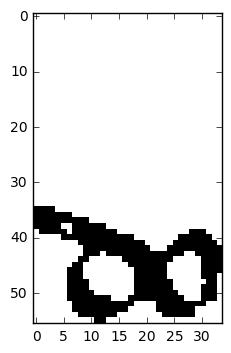

Pipeline 1
Cut 1 has been classified as good corresponding to char 's_mediana' with a confidence of 66.0341858864%
---
Elapsed time: 0.10765671730041504
Pipeline 2
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005506992340087891
Pipeline 3
Good cut with a confidence of 66.0341858864% by letter 's_mediana'
Good cut corresponding to letter 'd_mediana' with a confidence of 70.8997130394%
Good cut corresponding to letter 'd_alta' with a confidence of 24.2736101151%
Good cut corresponding to letter 'm' with a confidence of 4.14927825332%
---
Elapsed time: 0.08912944793701172
Pipeline 4
Bad cut with a confidence of 100.0%
---
Elapsed time: 0.005006551742553711


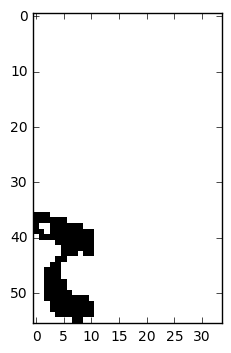

Pipeline 1
Cut 1 has been classified as good corresponding to char 'r' with a confidence of 60.0488245487%
---
Elapsed time: 0.10064578056335449
Pipeline 2
Bad cut with a confidence of 99.6698856354%
---
Elapsed time: 0.005507469177246094
Pipeline 3
Good cut with a confidence of 60.0488245487% by letter 'r'
Good cut corresponding to letter 'i' with a confidence of 62.6662373543%
Good cut corresponding to letter 'c' with a confidence of 12.9216477275%
Good cut corresponding to letter 't' with a confidence of 10.7260689139%
---
Elapsed time: 0.09714937210083008
Pipeline 4
Bad cut with a confidence of 99.6698856354%
---
Elapsed time: 0.0055084228515625


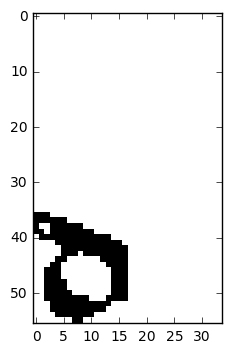

Pipeline 1
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 73.2561945915%
---
Elapsed time: 0.12618231773376465
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 81.0352504253%
Good cut corresponding to letter 'd_mediana' with a confidence of 18.9450889826%
Good cut corresponding to letter 'o' with a confidence of 0.013820809545%
---
Elapsed time: 0.013519525527954102
Pipeline 3
Good cut with a confidence of 73.2561945915% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 81.0352504253%
Good cut corresponding to letter 'd_mediana' with a confidence of 18.9450889826%
Good cut corresponding to letter 'o' with a confidence of 0.013820809545%
---
Elapsed time: 0.09864258766174316
Pipeline 4
Good cut with a confidence of 73.2561945915% by letter 'd_alta'
---
Elapsed time: 0.09013009071350098


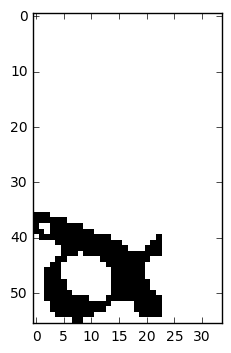

Pipeline 1
Cut 1 has been classified as good corresponding to char 'd_alta' with a confidence of 55.9814751148%
---
Elapsed time: 0.12568092346191406
Pipeline 2
Good cut corresponding to letter 'd_alta' with a confidence of 76.3394832611%
Good cut corresponding to letter 'd_mediana' with a confidence of 23.657989502%
Good cut corresponding to letter 'a' with a confidence of 0.00198975212697%
---
Elapsed time: 0.012017250061035156
Pipeline 3
Good cut with a confidence of 55.9814751148% by letter 'd_alta'
Good cut corresponding to letter 'd_alta' with a confidence of 76.3394832611%
Good cut corresponding to letter 'd_mediana' with a confidence of 23.657989502%
Good cut corresponding to letter 'a' with a confidence of 0.00198975212697%
---
Elapsed time: 0.13369345664978027
Pipeline 4
Good cut with a confidence of 55.9814751148% by letter 'd_alta'
---
Elapsed time: 0.10715508460998535


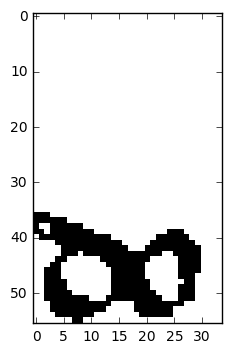

Pipeline 1
Bad cut
---
Elapsed time: 0.12618279457092285
Pipeline 2
Bad cut with a confidence of 99.9995708466%
---
Elapsed time: 0.007510662078857422
Pipeline 3
Bad cut
---
Elapsed time: 0.11767005920410156
Pipeline 4
Bad cut with a confidence of 99.9995708466%
---
Elapsed time: 0.00600886344909668


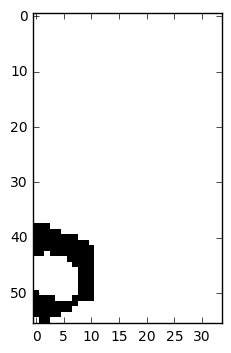

Pipeline 1
Bad cut
---
Elapsed time: 0.11516618728637695
Pipeline 2
Bad cut with a confidence of 99.7898101807%
---
Elapsed time: 0.007010459899902344
Pipeline 3
Bad cut
---
Elapsed time: 0.1326916217803955
Pipeline 4
Bad cut with a confidence of 99.7898101807%
---
Elapsed time: 0.006509304046630859


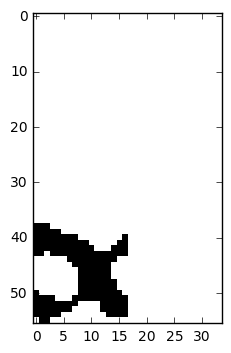

Pipeline 1
Bad cut
---
Elapsed time: 0.11166119575500488
Pipeline 2
Good cut corresponding to letter 'a' with a confidence of 94.2327678204%
Good cut corresponding to letter 'e' with a confidence of 3.06443274021%
Good cut corresponding to letter 'd_mediana' with a confidence of 0.812801346183%
---
Elapsed time: 0.01251840591430664
Pipeline 3
Bad cut
---
Elapsed time: 0.11867213249206543
Pipeline 4
---
Elapsed time: 0.1351947784423828


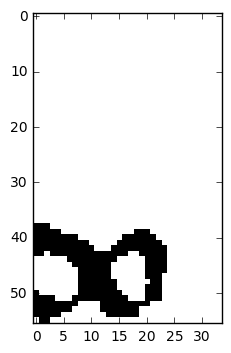

Pipeline 1
Bad cut
---
Elapsed time: 0.12417960166931152
Pipeline 2
Bad cut with a confidence of 99.2230534554%
---
Elapsed time: 0.007510662078857422
Pipeline 3
Bad cut
---
Elapsed time: 0.12267780303955078
Pipeline 4
Bad cut with a confidence of 99.2230534554%
---
Elapsed time: 0.0070095062255859375


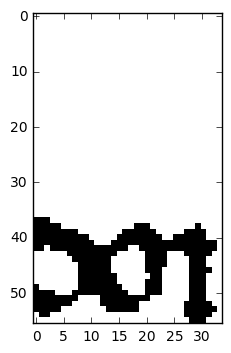

Pipeline 1
Bad cut
---
Elapsed time: 0.09663987159729004
Pipeline 2
Bad cut with a confidence of 99.9997258186%
---
Elapsed time: 0.005507469177246094
Pipeline 3
Bad cut
---
Elapsed time: 0.12367892265319824
Pipeline 4
Bad cut with a confidence of 99.9997258186%
---
Elapsed time: 0.009012937545776367


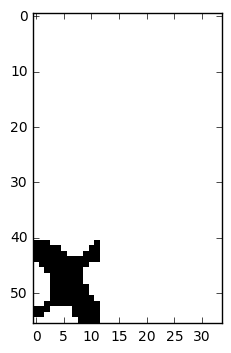

Pipeline 1
Cut 1 has been classified as good corresponding to char 'r' with a confidence of 59.806895256%
---
Elapsed time: 0.12417984008789062
Pipeline 2
Bad cut with a confidence of 99.1451382637%
---
Elapsed time: 0.005507946014404297
Pipeline 3
Good cut with a confidence of 59.806895256% by letter 'r'
Good cut corresponding to letter 'r' with a confidence of 39.0170902014%
Good cut corresponding to letter 'e' with a confidence of 38.4275734425%
Good cut corresponding to letter 'a' with a confidence of 11.9731768966%
---
Elapsed time: 0.08862805366516113
Pipeline 4
Bad cut with a confidence of 99.1451382637%
---
Elapsed time: 0.006008625030517578


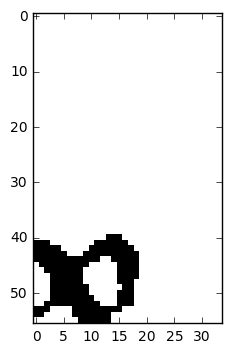

Pipeline 1
Bad cut
---
Elapsed time: 0.09864258766174316
Pipeline 2
Bad cut with a confidence of 65.9565210342%
---
Elapsed time: 0.008011579513549805
Pipeline 3
Bad cut
---
Elapsed time: 0.08812713623046875
Pipeline 4
Bad cut with a confidence of 65.9565210342%
---
Elapsed time: 0.005007028579711914


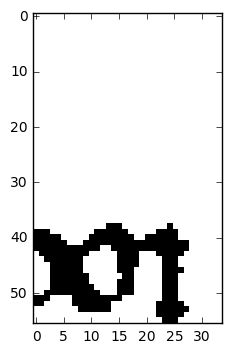

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 76.9118130207%
---
Elapsed time: 0.12367844581604004
Pipeline 2
Bad cut with a confidence of 74.9071121216%
---
Elapsed time: 0.007010221481323242
Pipeline 3
Good cut with a confidence of 76.9118130207% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 99.9999880791%
Good cut corresponding to letter 'd_mediana' with a confidence of 7.85354927757e-06%
Good cut corresponding to letter 'e' with a confidence of 7.79802320494e-06%
---
Elapsed time: 0.13118934631347656
Pipeline 4
Bad cut with a confidence of 74.9071121216%
---
Elapsed time: 0.005507946014404297


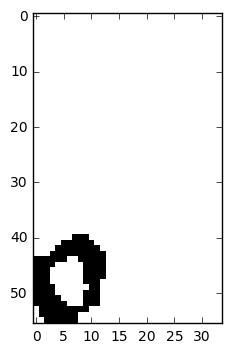

Pipeline 1
Cut 1 has been classified as good corresponding to char 'o' with a confidence of 98.4245419502%
---
Elapsed time: 0.11516666412353516
Pipeline 2
Good cut corresponding to letter 'o' with a confidence of 98.1848061085%
Good cut corresponding to letter 'e' with a confidence of 1.70192979276%
Good cut corresponding to letter 'c' with a confidence of 0.0570139556658%
---
Elapsed time: 0.015522480010986328
Pipeline 3
Good cut with a confidence of 98.4245419502% by letter 'o'
Good cut corresponding to letter 'o' with a confidence of 98.1848061085%
Good cut corresponding to letter 'e' with a confidence of 1.70192979276%
Good cut corresponding to letter 'c' with a confidence of 0.0570139556658%
---
Elapsed time: 0.12618207931518555
Pipeline 4
Good cut with a confidence of 98.4245419502% by letter 'o'
---
Elapsed time: 0.11466550827026367


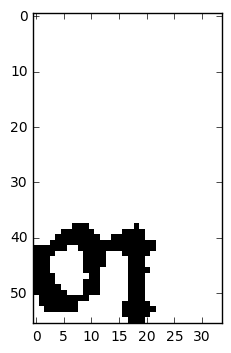

Pipeline 1
Bad cut
---
Elapsed time: 0.12668371200561523
Pipeline 2
Bad cut with a confidence of 98.1048583984%
---
Elapsed time: 0.006008148193359375
Pipeline 3
Bad cut
---
Elapsed time: 0.11867189407348633
Pipeline 4
Bad cut with a confidence of 98.1048583984%
---
Elapsed time: 0.00901341438293457


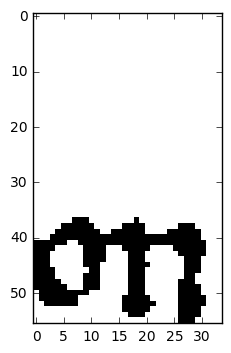

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 61.0418200493%
---
Elapsed time: 0.11867070198059082
Pipeline 2
Bad cut with a confidence of 77.0949065685%
---
Elapsed time: 0.006008625030517578
Pipeline 3
Good cut with a confidence of 61.0418200493% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 99.9999821186%
Good cut corresponding to letter 'd_mediana' with a confidence of 1.61265660381e-05%
Good cut corresponding to letter 'e' with a confidence of 1.09976450169e-07%
---
Elapsed time: 0.13219118118286133
Pipeline 4
Bad cut with a confidence of 77.0949065685%
---
Elapsed time: 0.0075113773345947266


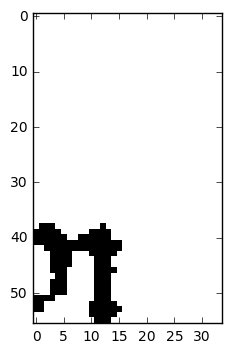

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 72.9267597198%
---
Elapsed time: 0.11566734313964844
Pipeline 2
Good cut corresponding to letter 'n' with a confidence of 99.8349010944%
Good cut corresponding to letter 'o' with a confidence of 0.0648385379463%
Good cut corresponding to letter 'e' with a confidence of 0.0567695009522%
---
Elapsed time: 0.01602315902709961
Pipeline 3
Good cut with a confidence of 72.9267597198% by letter 'n'
Good cut corresponding to letter 'n' with a confidence of 99.8349010944%
Good cut corresponding to letter 'o' with a confidence of 0.0648385379463%
Good cut corresponding to letter 'e' with a confidence of 0.0567695009522%
---
Elapsed time: 0.12568163871765137
Pipeline 4
Good cut with a confidence of 72.9267597198% by letter 'n'
---
Elapsed time: 0.12818527221679688


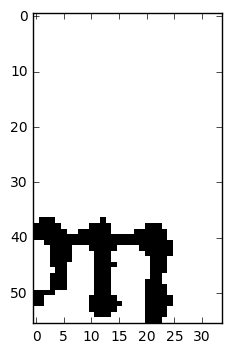

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 98.6061751842%
---
Elapsed time: 0.10765576362609863
Pipeline 2
Good cut corresponding to letter 'm' with a confidence of 99.9999642372%
Good cut corresponding to letter 'n' with a confidence of 2.12323655546e-05%
Good cut corresponding to letter 'd_mediana' with a confidence of 1.59681164291e-05%
---
Elapsed time: 0.012017011642456055
Pipeline 3
Good cut with a confidence of 98.6061751842% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 99.9999642372%
Good cut corresponding to letter 'n' with a confidence of 2.12323655546e-05%
Good cut corresponding to letter 'd_mediana' with a confidence of 1.59681164291e-05%
---
Elapsed time: 0.1387009620666504
Pipeline 4
Good cut with a confidence of 98.6061751842% by letter 'm'
---
Elapsed time: 0.11867165565490723


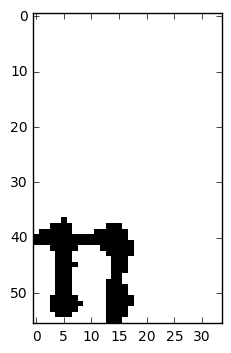

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 97.4084556103%
---
Elapsed time: 0.13369345664978027
Pipeline 2
Good cut corresponding to letter 'n' with a confidence of 99.9913036823%
Good cut corresponding to letter 'u' with a confidence of 0.00798458131612%
Good cut corresponding to letter 'o' with a confidence of 0.00055232694649%
---
Elapsed time: 0.013520240783691406
Pipeline 3
Good cut with a confidence of 97.4084556103% by letter 'n'
Good cut corresponding to letter 'n' with a confidence of 99.9913036823%
Good cut corresponding to letter 'u' with a confidence of 0.00798458131612%
Good cut corresponding to letter 'o' with a confidence of 0.00055232694649%
---
Elapsed time: 0.146712064743042
Pipeline 4
Good cut with a confidence of 97.4084556103% by letter 'n'
---
Elapsed time: 0.11015892028808594


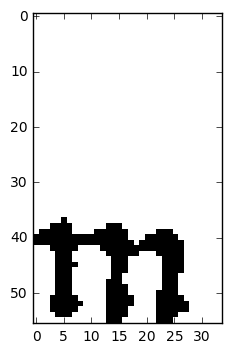

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 97.038269043%
---
Elapsed time: 0.10414934158325195
Pipeline 2
Good cut corresponding to letter 'm' with a confidence of 100.0%
Good cut corresponding to letter 'n' with a confidence of 9.60908774772e-07%
Good cut corresponding to letter 'd_mediana' with a confidence of 3.17847310971e-09%
---
Elapsed time: 0.016524076461791992
Pipeline 3
Good cut with a confidence of 97.038269043% by letter 'm'
Good cut corresponding to letter 'm' with a confidence of 100.0%
Good cut corresponding to letter 'n' with a confidence of 9.60908774772e-07%
Good cut corresponding to letter 'd_mediana' with a confidence of 3.17847310971e-09%
---
Elapsed time: 0.10515260696411133
Pipeline 4
Good cut with a confidence of 97.038269043% by letter 'm'
---
Elapsed time: 0.10715508460998535


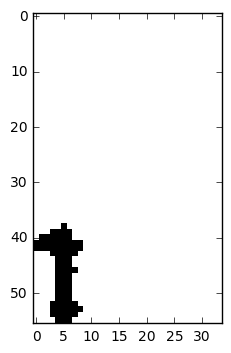

Pipeline 1
Cut 1 has been classified as good corresponding to char 'i' with a confidence of 91.3277626038%
---
Elapsed time: 0.12417960166931152
Pipeline 2
Bad cut with a confidence of 86.0872745514%
---
Elapsed time: 0.005507946014404297
Pipeline 3
Good cut with a confidence of 91.3277626038% by letter 'i'
Good cut corresponding to letter 'i' with a confidence of 99.9985992908%
Good cut corresponding to letter 't' with a confidence of 0.00108259573608%
Good cut corresponding to letter 'l' with a confidence of 0.000141366979278%
---
Elapsed time: 0.09563851356506348
Pipeline 4
Bad cut with a confidence of 86.0872745514%
---
Elapsed time: 0.006510257720947266


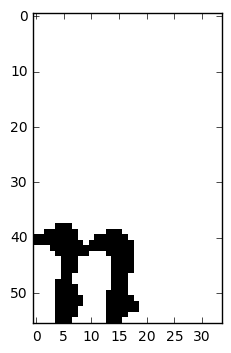

Pipeline 1
Cut 1 has been classified as good corresponding to char 'n' with a confidence of 95.8248436451%
---
Elapsed time: 0.09463691711425781
Pipeline 2
Good cut corresponding to letter 'n' with a confidence of 99.996984005%
Good cut corresponding to letter 'o' with a confidence of 0.00143019105963%
Good cut corresponding to letter 'u' with a confidence of 0.00117087029139%
---
Elapsed time: 0.014020442962646484
Pipeline 3
Good cut with a confidence of 95.8248436451% by letter 'n'
Good cut corresponding to letter 'n' with a confidence of 99.996984005%
Good cut corresponding to letter 'o' with a confidence of 0.00143019105963%
Good cut corresponding to letter 'u' with a confidence of 0.00117087029139%
---
Elapsed time: 0.22031831741333008
Pipeline 4
Good cut with a confidence of 95.8248436451% by letter 'n'
---
Elapsed time: 0.13068914413452148


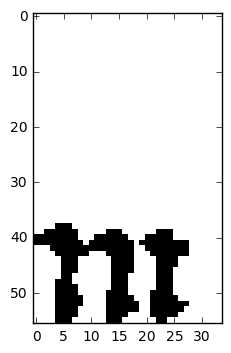

Pipeline 1
Cut 1 has been classified as good corresponding to char 'm' with a confidence of 85.259437561%
---
Elapsed time: 0.1251816749572754
Pipeline 2
Good cut corresponding to letter 'm' with a confidence of 100.0%
Good cut corresponding to letter 'n' with a confidence of 1.50026685519e-08%
Good cut corresponding to letter 'd_mediana' with a confidence of 5.56126542386e-10%
---
Elapsed time: 0.013018369674682617
Pipeline 3
Good cut with a confidence of 85.259437561% by letter 'm'


In [ ]:
for i in range(0,len(cuts)):
    u.plot_image(cuts[i], (img_cols, img_rows))
    print("Pipeline 1")
    predict_pipeline1([cuts[i]], count_letter=False)
    print("Pipeline 2")
    predict_pipeline2([cuts[i]], count_letter=False)
    print("Pipeline 3")
    predict_pipeline3([cuts[i]], count_letter=False)
    print("Pipeline 4")
    predict_pipeline4([cuts[i]], count_letter=False)